In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import hevc_decode_mu
import tqdm
from math import floor
plt.style.use('seaborn-whitegrid')

/tmp/ipykernel_10723/4031964026.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [2]:
mu = hevc_decode_mu.mu()
mu #fps

118.0

In [3]:
target = 100  # [ms] The target sojourn time 
target = 20  # [ms] The target sojourn time - TeSo sec5.21 22.886 v0.2.0 - 2016 Study on enhancement of 3GPP Support for 5G V2X Services

In [4]:
target_prob = 0.9999  # The reliability, 99.99% of all jobs should finish withing the target sojourn time 5G-Americas infrastructure-assisted perception
target_prob = 0.99999  # The reliability, 99.999% of all jobs should finish withing the target sojourn time - TeSo sec5.21 22.886 v0.2.0 - 2016 Study on enhancement of 3GPP Support for 5G V2X Services

In [5]:
highway_lambdas = pd.read_csv('roads-lambdas/highway-corso-unita-italia-lambdas.csv', parse_dates=[2])[['end_time', 'lambda_v2x', 'flow']].set_index('end_time')
industrial_lambdas = pd.read_csv('roads-lambdas/industrial-corso-agneli.json-lambdas.csv', parse_dates=[2])[['end_time', 'lambda_v2x', 'flow']].set_index('end_time')
lowemission_lambdas = pd.read_csv('roads-lambdas/low-emissions-corso-san-maurizio-lambdas.csv', parse_dates=[2])[['end_time', 'lambda_v2x', 'flow']].set_index('end_time')
residential_lambdas = pd.read_csv('roads-lambdas/residential-corso-unione-sovietica-lambdas.csv', parse_dates=[2])[['end_time', 'lambda_v2x', 'flow']].set_index('end_time')

# Look for the best approximation for every $(R,\rho)$

In [6]:
# README: Use the most up-to-date one
data = pd.read_csv('sweep_summary.csv')


def find_best(row):
    A = row['error A']
    B = row['error B']
    C = row['error C']
    D = row['error D']
    E = row['error E']
    F = row['error F']
    if A == min([A, B, C, D, E, F]):
        return 1
    if B == min([A, B, C, D, E, F]):
        return 2
    if C == min([A, B, C, D, E, F]):
        return 3
    if D == min([A, B, C, D, E, F]):
        return 4
    if E == min([A, B, C, D, E, F]):
        return 5
    if F == min([A, B, C, D, E, F]):
        return 6

# Here we obtain the best approx
data['best'] = data.apply(lambda row: find_best(row), axis=1)

In [7]:
data[['R', 'rho', 'best']].head(4)

R   rho  best
0  1  0.01     5
1  1  0.02     5
2  1  0.03     5
3  1  0.04     5

In [8]:
# Here we store the best approx. for every (R,rho) pair
cdfs = {}

# Derived from experiments parameters
infty = 130
mc_limits = { # R: mc_limit
    1: 22, 2:22, 3:22,
    4: 13, 5:7, 6:5, 7:4,
    8:3, 9:3, 10:2
}

#for R in tqdm.tqdm_notebook(range(1, 11)):
for R in range(1, 11):
    for rho in np.linspace(0.01, 0.99, 99):
        rho_r = round(rho, 2)
        method_idx = data[(data['R']==R) & (data['rho']==rho_r)]['best'].values[0]
        best_method = ['A','B','C','D','E','F'][method_idx-1]
        file = f'sweep/method{best_method}/mc_limit={mc_limits[R]}-infty={infty}-R={R}-rho={rho_r}.csv'
        cdf = pd.read_csv(file, index_col=0)
        cdfs[(R, round(rho, 2))] = cdf

# Load Ciw CDFs using uniform, exp, & det service times

In [9]:
# CDFs for each service time distribution
exp_cdfs = {}
det_cdfs = {}
unif_cdfs = {}


#for R in tqdm.tqdm_notebook(range(1, 11)):
for R in range(1, 11):
    for rho in np.linspace(0.01, 0.99, 99):
        rho_r = round(rho, 2)
        
        # Exp
        file = f'sweep-expon/expon-R={R}-rho={rho_r}.csv'
        cdf = pd.read_csv(file, index_col=0)
        exp_cdfs[(R, round(rho, 2))] = cdf
        
        # Det
        file = f'sweep-deterministic/deterministic-R={R}-rho={rho_r}.csv'
        cdf = pd.read_csv(file, index_col=0)
        det_cdfs[(R, round(rho, 2))] = cdf
        
        # Unif
        # file = f'sweep-uniform/uniform-R={R}-rho={rho_r}.csv' # U(o,2/mu)
        file = f'sweep-nonzero-uniform/nonzero-uniform-R={R}-rho={rho_r}.csv'
        cdf = pd.read_csv(file, index_col=0)
        unif_cdfs[(R, round(rho, 2))] = cdf

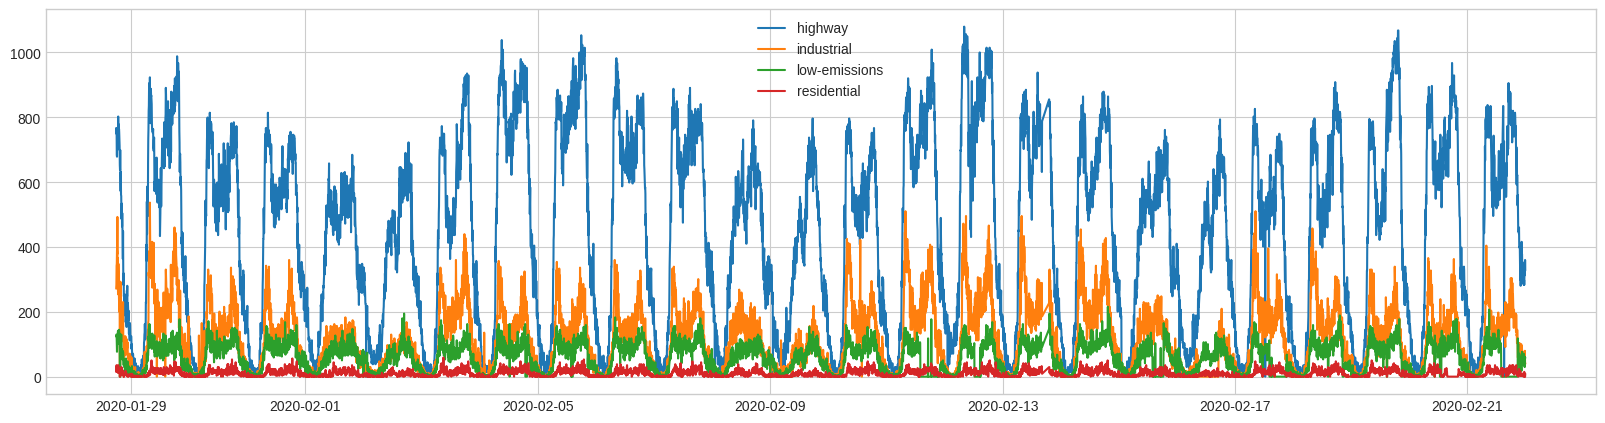

In [17]:
fig, ax = plt.subplots(1, figsize=(20, 5))
ax.plot(highway_lambdas['lambda_v2x'], label='highway')
ax.plot(industrial_lambdas['lambda_v2x'], label='industrial')
ax.plot(lowemission_lambdas['lambda_v2x'], label='low-emissions')
ax.plot(residential_lambdas['lambda_v2x'], label='residential')
plt.legend()
plt.show()

In [10]:
def get_percentiles(lmbda, mu, R, p, cdfs=cdfs):
    """
    Obtains the pth-percentile for a given lambda, mu and R values.
    """
    rho = round((lmbda / (mu * R)) + 0.005, 2)
    if rho >= 1:
        return np.nan
    cdf = cdfs[(R, rho)]
    percentile = cdf[cdf['cdf'] >= p]['sojourn_time'].min()
    return percentile

In [11]:
for R in range(1, 11):
    highway_lambdas[f'R={R} 99.999th'] = highway_lambdas['lambda_v2x'].apply(lambda l: get_percentiles(l, mu, R, 0.99999))
    industrial_lambdas[f'R={R} 99.999th'] = industrial_lambdas['lambda_v2x'].apply(lambda l: get_percentiles(l, mu, R, 0.99999))
    lowemission_lambdas[f'R={R} 99.999th'] = lowemission_lambdas['lambda_v2x'].apply(lambda l: get_percentiles(l, mu, R, 0.99999))
    residential_lambdas[f'R={R} 99.999th'] = residential_lambdas['lambda_v2x'].apply(lambda l: get_percentiles(l, mu, R, 0.99999))

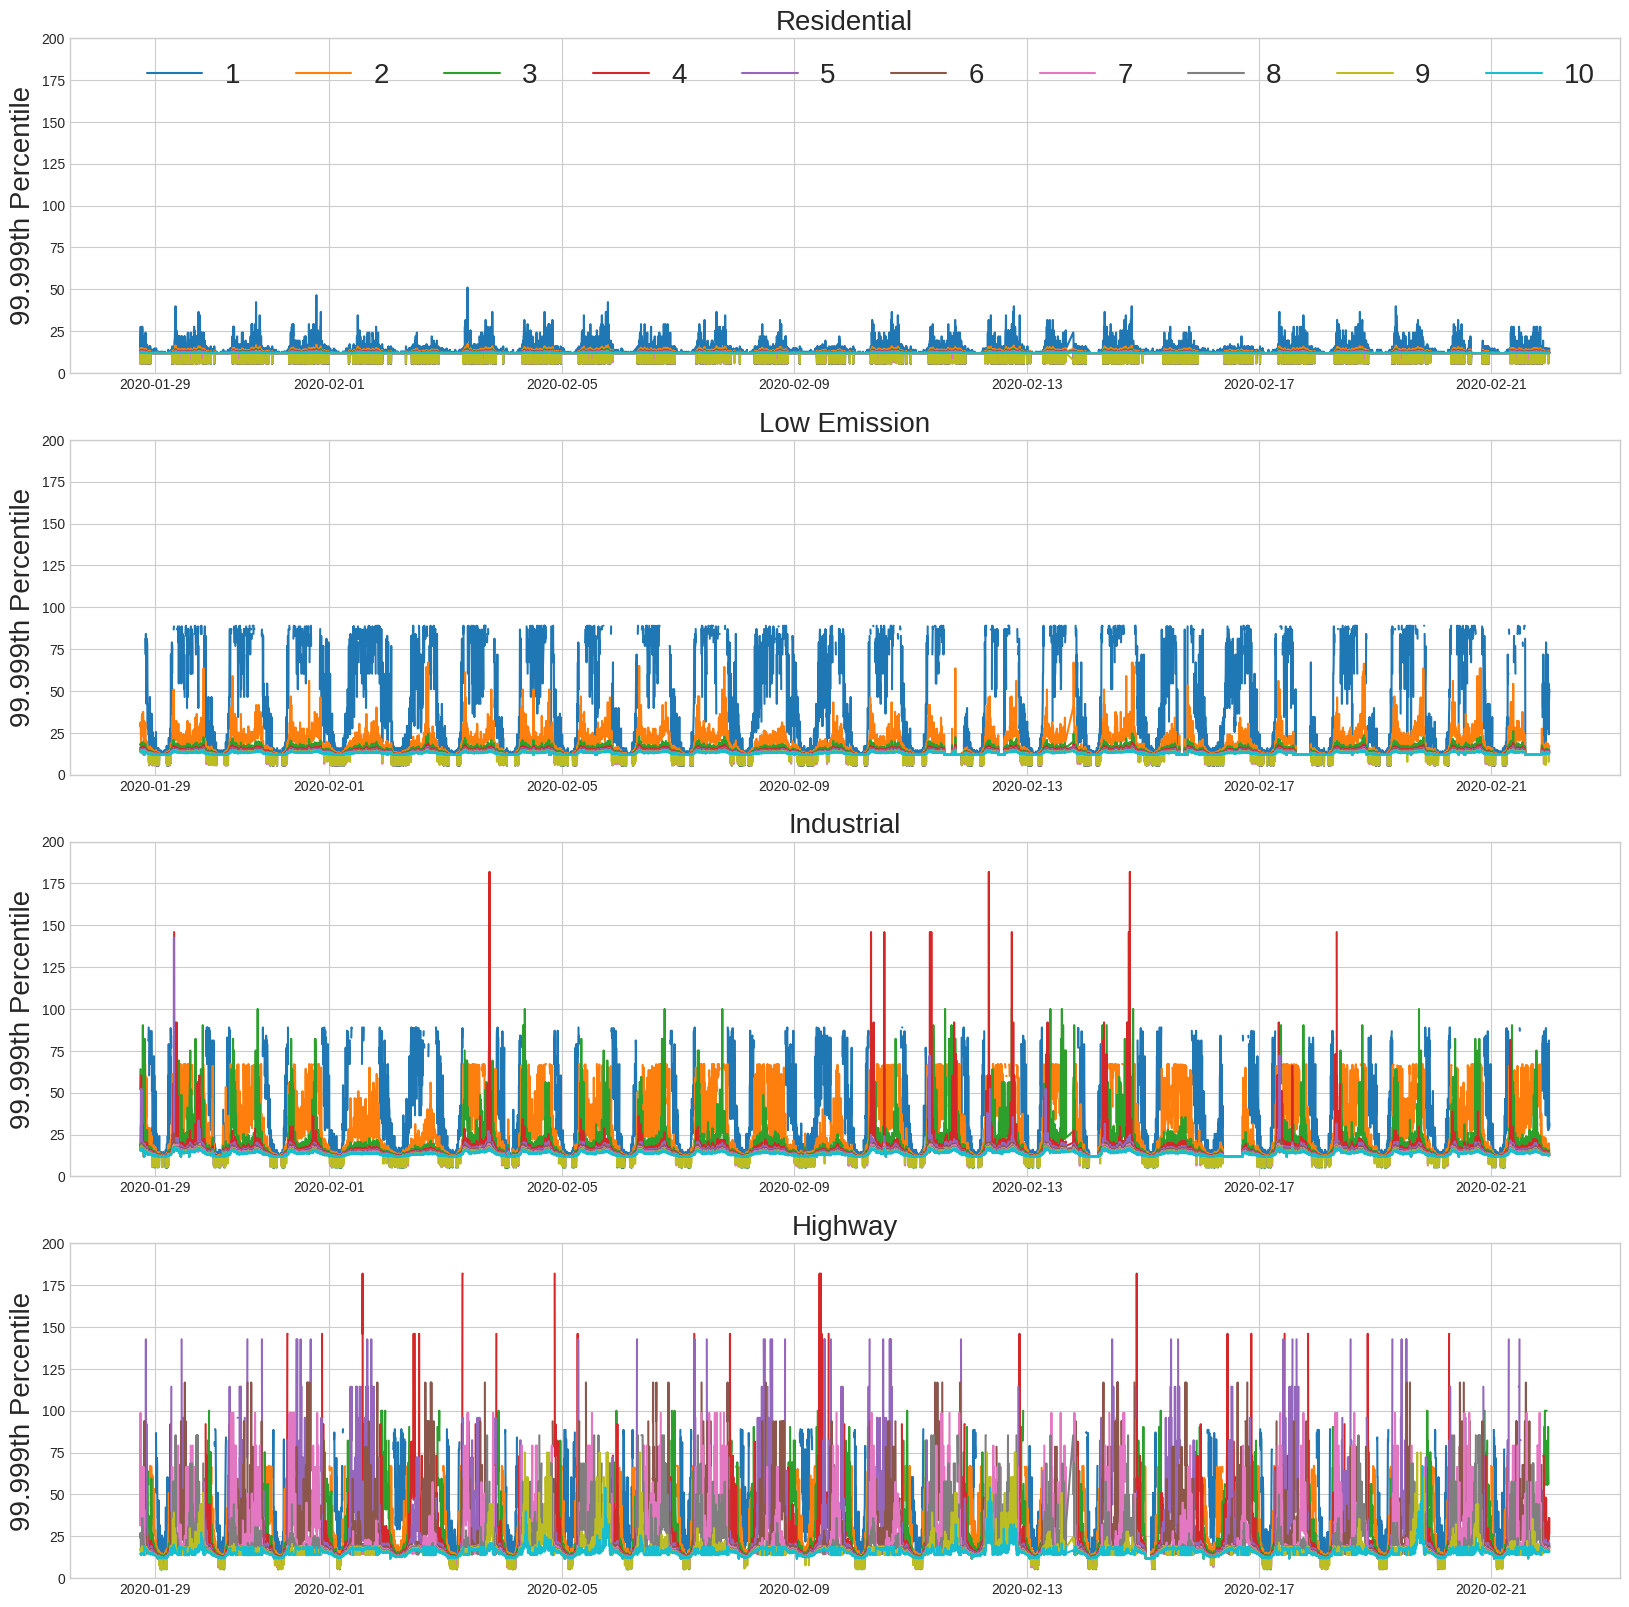

In [21]:
fig, axarr = plt.subplots(4, figsize=(20, 20))
for R in range(1, 11):
    axarr[0].plot(residential_lambdas[f'R={R} 99.999th'], label=R)
    axarr[1].plot(lowemission_lambdas[f'R={R} 99.999th'])
    axarr[2].plot(industrial_lambdas[f'R={R} 99.999th'])
    axarr[3].plot(highway_lambdas[f'R={R} 99.999th'])
axarr[0].set_title('Residential', fontsize=20)
axarr[1].set_title('Low Emission', fontsize=20)
axarr[2].set_title('Industrial', fontsize=20)
axarr[3].set_title('Highway', fontsize=20)
axarr[0].set_ylabel('99.999th Percentile', fontsize=20)
axarr[1].set_ylabel('99.999th Percentile', fontsize=20)
axarr[2].set_ylabel('99.999th Percentile', fontsize=20)
axarr[3].set_ylabel('99.999th Percentile', fontsize=20)
axarr[0].set_ylim(0, 200)
axarr[1].set_ylim(0, 200)
axarr[2].set_ylim(0, 200)
axarr[3].set_ylim(0, 200)
axarr[0].legend(ncol=10, fontsize=20)

In [11]:
def get_prob_exceeding_target(lmbda, mu, R, target):
    """
    Obtains the probability of exceeding the target time for a given lambda, mu and R values.
    """
    rho = round((lmbda / (mu * R)) + 0.005, 2)
    if rho >= 1:
        return np.nan
    cdf = cdfs[(R, rho)]
    prob = 1 - cdf[cdf['sojourn_time'] >= target]['cdf'].min()
    return prob

In [14]:
for R in tqdm.tqdm_notebook(range(1, 11)):
    highway_lambdas[f'R={R} P(>10)'] = highway_lambdas['lambda_v2x'].apply(lambda l: get_prob_exceeding_target(l, mu, R, target))
    industrial_lambdas[f'R={R} P(>10)'] = industrial_lambdas['lambda_v2x'].apply(lambda l: get_prob_exceeding_target(l, mu, R, target))
    lowemission_lambdas[f'R={R} P(>10)'] = lowemission_lambdas['lambda_v2x'].apply(lambda l: get_prob_exceeding_target(l, mu, R, target))
    residential_lambdas[f'R={R} P(>10)'] = residential_lambdas['lambda_v2x'].apply(lambda l: get_prob_exceeding_target(l, mu, R, target))

/tmp/ipykernel_23232/691134033.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for R in tqdm.tqdm_notebook(range(1, 11)):
Widget Javascript not detected.  It may not be installed or enabled properly.


AttributeError: 'FloatProgress' object has no attribute 'style'

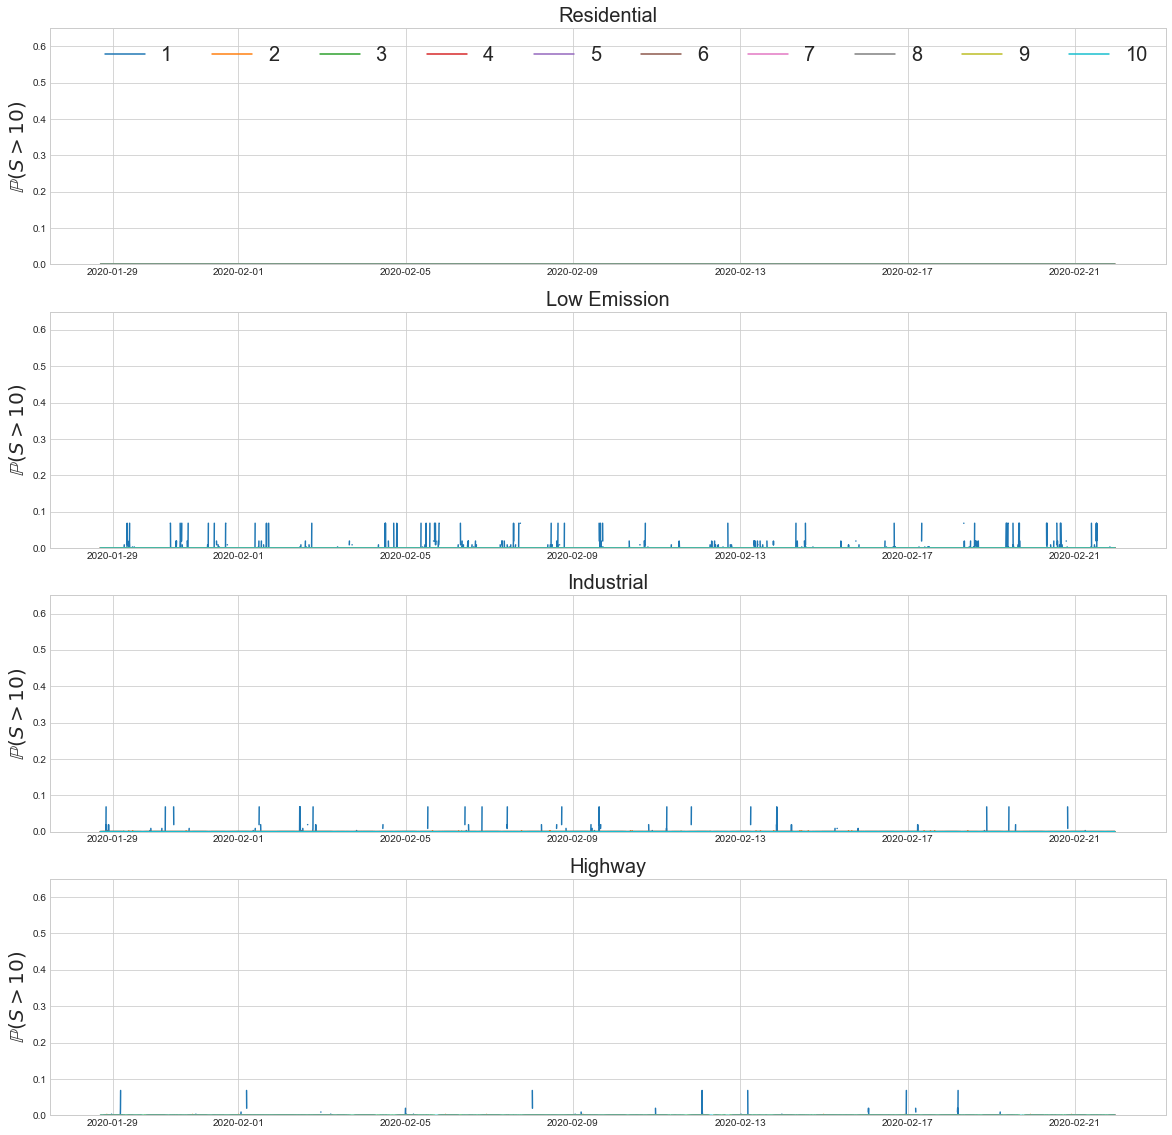

In [16]:
fig, axarr = plt.subplots(4, figsize=(20, 20))
for R in range(1, 11):
    axarr[0].plot(residential_lambdas[f'R={R} P(>10)'], label=R)
    axarr[1].plot(lowemission_lambdas[f'R={R} P(>10)'])
    axarr[2].plot(industrial_lambdas[f'R={R} P(>10)'])
    axarr[3].plot(highway_lambdas[f'R={R} P(>10)'])
axarr[0].set_title('Residential', fontsize=20)
axarr[1].set_title('Low Emission', fontsize=20)
axarr[2].set_title('Industrial', fontsize=20)
axarr[3].set_title('Highway', fontsize=20)
axarr[0].set_ylabel(r'$\mathbb{P}(S > 10)$', fontsize=20)
axarr[1].set_ylabel(r'$\mathbb{P}(S > 10)$', fontsize=20)
axarr[2].set_ylabel(r'$\mathbb{P}(S > 10)$', fontsize=20)
axarr[3].set_ylabel(r'$\mathbb{P}(S > 10)$', fontsize=20)
axarr[0].set_ylim(0, 0.65)
axarr[1].set_ylim(0, 0.65)
axarr[2].set_ylim(0, 0.65)
axarr[3].set_ylim(0, 0.65)
axarr[0].legend(ncol=10, fontsize=20)

In [13]:
def get_min_R_above_target_prob(row, target_prob):
    ps = row[[f'R={R} P(>10)' for R in range(1, 11)]]
    satisfied_Rs = [R+1 if p < (1 - target_prob) else np.nan for R, p in enumerate(ps)]
    if all(np.isnan(satisfied_Rs)):
        return np.nanroad is equipped with an Edge server with R = 10
available CPUs performing video decoding of H.265/HEVC
video streams [50] and object detection tasks. We use the
results in [51], [52]
    minR = np.nanmin(satisfied_Rs)
    return minR

SyntaxError: invalid syntax (3481996339.py, line 5)

In [ ]:
highway_lambdas['Best R'] = highway_lambdas.apply(lambda row: get_min_R_above_target_prob(row, target_prob), axis=1)
industrial_lambdas['Best R'] = industrial_lambdas.apply(lambda row: get_min_R_above_target_prob(row, target_prob), axis=1)
lowemission_lambdas['Best R'] = lowemission_lambdas.apply(lambda row: get_min_R_above_target_prob(row, target_prob), axis=1)
residential_lambdas['Best R'] = residential_lambdas.apply(lambda row: get_min_R_above_target_prob(row, target_prob), axis=1)

In [19]:
fig, axarr = plt.subplots(4, figsize=(20, 20))
axarr2 = [axarr[i].twinx() for i in range(4)]
axarr2[0].plot(residential_lambdas['lambda_v2x'], c='black', alpha=0.3)
axarr2[1].plot(lowemission_lambdas['lambda_v2x'], c='black', alpha=0.3)
axarr2[2].plot(industrial_lambdas['lambda_v2x'], c='black', alpha=0.3)
axarr2[3].plot(highway_lambdas['lambda_v2x'], c='black', alpha=0.3)
axarr2[0].set_title('Residential', fontsize=20)
axarr2[1].set_title('Low Emission', fontsize=20)
axarr2[2].set_title('Industrial', fontsize=20)
axarr2[3].set_title('Highway', fontsize=20)
axarr[0].plot(residential_lambdas['Best R'], c='darkorange')
axarr[1].plot(lowemission_lambdas['Best R'], c='darkorange')
axarr[2].plot(industrial_lambdas['Best R'], c='darkorange')
axarr[3].plot(highway_lambdas['Best R'], c='darkorange')
for i in range(4):
    axarr[i].set_ylim(0, 11)
    axarr2[i].set_ylabel('Lambda', fontsize=20)
    axarr[i].set_ylabel('Optimal CPUs', fontsize=20)
plt.plot()

[]

# Vehicular traffic vs. 99.99% latency

In [20]:
ax = plt.gca()

for R in range(1,11):
    highway_lambdas[['flow', f'R={R} 99.99th']].sort_values('flow').drop_duplicates().plot(x='flow', y=f'R={R} 99.99th', ax=ax, label=f'R={R}', figsize=(8,4))
plt.xlabel('traffic [vehicles/hour]')
plt.ylabel('99.99% latency [ms]')

Text(0, 0.5, '99.99% latency [ms]')

# Peak hours propagation allowance

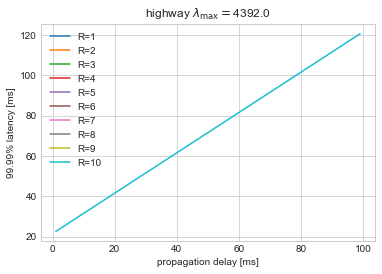

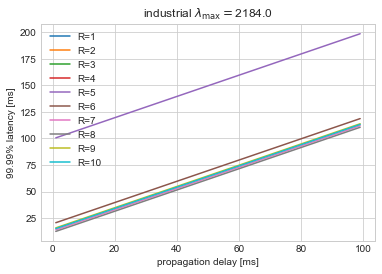

In [21]:
for road, label in [(highway_lambdas, 'highway'),
                    (industrial_lambdas, 'industrial'),
                    (lowemission_lambdas, 'low-emission'),
                    (residential_lambdas, 'residential')]:
    for R in range(1,11):
        flow, latency99 = road[['flow', f'R={R} 99.99th']].sort_values('flow').tail(1).values[0]
        plt.plot(range(1,100), [latency99 + i for i in range(1,100)], label=f'R={R}')
    plt.legend()
    plt.title(label + r' $\lambda_\max=$' + f'{flow}')
    plt.xlabel('propagation delay [ms]')
    plt.ylabel('99.99% latency [ms]')
    plt.show()

# Derive a smart scaling strategy

 1. at instant $t$ we have a given $\lambda$;
 2. we decrease $R$ from 10 down to 1; and
 2. we stop when $\tfrac{\lambda}{R\mu}$ 99.999% latency $>20$ms

In [12]:
pusch={"snrs": [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 "max_reps":   [ 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 "throughput": [ 4.7597, 59.4960, 77.9398, 79.4272, 116.6122, 118.9920, 118.9920, 118.9920, 142.4929, 235.9016, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840],
 "NFrames": 40,"MCS": "256QAM","SCS": 60,"NSizeGrid": 138}

# PUSCH results with 4.8GHz
pusch={"snrs":    [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
"max_reps":       [ 3, 3, 3, 2, 2, 1, 1, 1, 1, 1, 0,  0,   0,  0,  0,  0, 0, 0, 0, 0, 0],
"throughput": [ 4.7597, 59.4960, 77.9398, 79.4272, 116.6122, 118.9920, 118.9920, 118.9920, 142.4929, 235.9016, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840, 237.9840],
 "NFrames": 40,"MCS": "256QAM","SCS": 60,"NSizeGrid": 138}

pdsch={"snrs": [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 "max_reps":   [ 3, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 "throughput": [ 199.6408, 216.4483, 246.7839, 292.2872, 327.1321, 327.9520, 327.9520, 327.9520, 327.9520, 459.9527, 552.5991, 647.2953, 655.9040, 655.9040, 655.9040, 655.9040, 655.9040, 655.9040, 655.9040, 655.9040, 655.9040],
 "NFrames": 40,"MCS": "256QAM","SCS": 60,"NSizeGrid": 138}


In [13]:
def smart_scaling(lmbd, mu, tgt, p, cdf, data=None, nr_delay=0.25, max_admission=100000000000):
    # lmbd: lambda
    # mu: mu
    # tgt: target sojourn time
    # p: percentile, e.g., 0.9999 (the 99.99% percentile)
    # cdf: the CDF function to use
    # data: (optional) 
    #   if data=None it is simulation CDF
    #   if data=DataFrame it is ['R','rho','best']
    # nr_delay: NR delay added in transmission (w/ mu=2 a slot takes 0.25ms)
    # max_admission: max admitted fps in the network
    #
    # returns: R: min R to get the p-percentile of delay <tgt
    #          delp: p-percentile delay
    #          method: None/{A,B,C,D,E,F}
    #          eps: percentage of requests (lambda) sent to a 10CPU server
    #          admitted_lmbd: admitted fps
    
    # Turn off CPUs when there is no demand
    if lmbd==0:
        return 0, 0, None, 1, 0

    # Get admitted lambda [fps]
    lmbd = min(lmbd, max_admission)
    admitted_lmbd = lmbd
    
    # Substract the worst NR RTT -> computing tgt delay
    comp_tgt = tgt - nr_delay
    
    # Scale #CPUs up to 10 until we meet tgt delay
    servers = 1 # we assume only 1 server of 10 CPUs is required
    delp = comp_tgt+1
    R = 0
    while R<10 and delp>comp_tgt:
        R += 1
        rho = lmbd/(R*mu)
        if rho<=0.85: # we set the 0.85 load to prevent accuracy degradation
            delp = get_percentiles(lmbd, mu, R, p, cdf)
            delp = comp_tgt+1 if np.isnan(delp) else delp

    # If 10CPUs are not enough, check the maximum load admitted to meet the percentile
    # then send the rest of the load to a new server with up to 10 CPUs
    delp_residual = delp
    eps = 1
    extra_servers = delp>comp_tgt
    if delp>comp_tgt:
        # Find the percentage of demand (eps) we can accomodate in 10CPUs -> lmbd10
        R = 10
        while delp>comp_tgt:
            eps -= 0.01
            # lmbd10 = lmbd*eps/(R*mu) # BEFORE; WRONG CODE
            lmbd10 = lmbd*eps
            if lmbd10/(R*mu) <= 0.85: # force attended demand smaller than 80%
                delp = get_percentiles(lmbd10, mu, R, p, cdf)
                delp = comp_tgt+1 if np.isnan(delp) else delp

        # How many servers of R=10 CPUs do we need?
        servers = floor(1/eps)

        # What is the residual demand for a new R=10 CPU server?
        lmbd_residual = (1-eps) * lmbd
    
        # Find how many CPUs are required for the residual demand
        R = 0
        delp_residual = 100000000
        while R<10 and delp_residual>comp_tgt:
            R += 1
            rho = lmbd_residual/(R*mu)
            if rho<=0.85: # force attended demand smaller than 80%
                delp_residual = get_percentiles(lmbd_residual, mu, R, p, cdf)
                delp_residual = comp_tgt+1 if np.isnan(delp_residual) else delp_residual

        # Set the total num of servers as the original 10 plus the additional ones
        R = 10 + R
        
        # Set lmbd as lmbd_residual to obtain the best method for the residual demand
        lmbd = lmbd_residual if lmbd_residual > 0 else lmbd10
            
    # Get the medhod? used by the approx.
    rho_r = round(lmbd/(R*mu), 2)
    #print('rho_r', rho_r, 'R', R)
    method_idx = None
    if isinstance(data, pd.DataFrame):
        #print(delp, lmbd, mu,R,rho_r, rho)
        #print(data[(data['R']==R) & (data['rho']==rho_r)])
        method_idx = data[(data['R']==min(10,R)) & (data['rho']==rho_r)]['best'].values[0]
    
    return R, max(delp,delp_residual), method_idx, eps, admitted_lmbd

In [14]:
# Compute the maximum admission for 5,10,15 SNR by means of fps
# throughput is in Mbps, and a frame is 260kb
max_admission5dB = pusch['throughput'][5] * 1024 / 260
max_admission10dB = pusch['throughput'][10] * 1024 / 260
max_admission15dB = pusch['throughput'][15] * 1024 / 260

In [15]:
# 5dB SINR - 1 rep in UL
off = 100
period = 288*4
nr_delay=0.5
res_h = highway_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs, data=data, nr_delay=nr_delay, max_admission=max_admission5dB))
res_i = industrial_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs, data=data, nr_delay=nr_delay, max_admission=max_admission5dB))
res_l = lowemission_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs, data=data, nr_delay=nr_delay, max_admission=max_admission5dB))
res_r = residential_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs, data=data, nr_delay=nr_delay, max_admission=max_admission5dB))

In [16]:
#10dB - 0 reps in UL 
nr_delay=0.25
res_h10dB = highway_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs, data=data, nr_delay=nr_delay, max_admission=max_admission10dB))
res_i10dB = industrial_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs, data=data, nr_delay=nr_delay, max_admission=max_admission10dB))
res_l10dB = lowemission_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs, data=data, nr_delay=nr_delay, max_admission=max_admission10dB))
res_r10dB = residential_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs, data=data, nr_delay=nr_delay, max_admission=max_admission10dB))

In [17]:
#15dB - 0 reps in UL 
nr_delay=0.25
res_h15dB = highway_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs, data=data, nr_delay=nr_delay, max_admission=max_admission15dB))
res_i15dB = industrial_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs, data=data, nr_delay=nr_delay, max_admission=max_admission15dB))
res_l15dB = lowemission_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs, data=data, nr_delay=nr_delay, max_admission=max_admission15dB))
res_r15dB = residential_lambdas['lambda_v2x'][off:period+off].apply(lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs, data=data, nr_delay=nr_delay, max_admission=max_admission15dB))

In [18]:
################################
# Obtain the table metrics
################################
highway_max_idx = np.argmax(highway_lambdas['lambda_v2x'][off:period+off].values)
industrial_max_idx = np.argmax(industrial_lambdas['lambda_v2x'][off:period+off].values)
lowemission_max_idx = np.argmax(lowemission_lambdas['lambda_v2x'][off:period+off].values)
residential_max_idx = np.argmax(residential_lambdas['lambda_v2x'][off:period+off].values)

# Print peak CPUs
print('==Peak CPUs==')
print(' residential 5dB:', max([res_r.values[i][0] for i in range(len(res_r))]), 'CPUs')
print(' residential 10dB:', max([res_r10dB.values[i][0] for i in range(len(res_r10dB))]), 'CPUs')
print(' residential 15dB:', max([res_r15dB.values[i][0] for i in range(len(res_r15dB))]), 'CPUs')
print(' ----')
print(' industrial 5dB:', max([res_i.values[i][0] for i in range(len(res_i))]), 'CPUs')
print(' industrial 10dB:', max([res_i10dB.values[i][0] for i in range(len(res_i10dB))]), 'CPUs')
print(' industrial 15dB:', max([res_i15dB.values[i][0] for i in range(len(res_i15dB))]), 'CPUs')
print(' ----')
print(' highway 5dB:', max([res_h.values[i][0] for i in range(len(res_h))]), 'CPUs')
print(' highway 10dB:', max([res_h10dB.values[i][0] for i in range(len(res_h10dB))]), 'CPUs')
print(' highway 15dB:', max([res_h15dB.values[i][0] for i in range(len(res_h15dB))]), 'CPUs')
print(' ----')

print('==peak admission==')
print(' residential  5dB', pusch['throughput'][5] / (residential_lambdas['lambda_v2x'][off:period+off][residential_max_idx]*260/1024) )
print(' residential  10dB', pusch['throughput'][10] / (residential_lambdas['lambda_v2x'][off:period+off][residential_max_idx]*260/1024) )
print(' residential  15dB', pusch['throughput'][15] / (residential_lambdas['lambda_v2x'][off:period+off][residential_max_idx]*260/1024) )
print(' ----')
print(' industrial  5dB', pusch['throughput'][5] / (industrial_lambdas['lambda_v2x'][off:period+off][industrial_max_idx]*260/1024) )
print(' industrial  10dB', pusch['throughput'][10] / (industrial_lambdas['lambda_v2x'][off:period+off][industrial_max_idx]*260/1024) )
print(' industrial  15dB', pusch['throughput'][15] / (industrial_lambdas['lambda_v2x'][off:period+off][industrial_max_idx]*260/1024) )
print(' ----')
print(' highway  5dB', pusch['throughput'][5] / (highway_lambdas['lambda_v2x'][off:period+off][highway_max_idx]*260/1024)  )
print(' highway  10dB', pusch['throughput'][10] / (highway_lambdas['lambda_v2x'][off:period+off][highway_max_idx]*260/1024)  )
print(' highway  15dB', pusch['throughput'][15] / (highway_lambdas['lambda_v2x'][off:period+off][highway_max_idx]*260/1024)  )

print('==max delay 99.999-percentile==')
print(' residential 5dB:', max([res_r.values[i][1] for i in range(len(res_r))])+.5, 'ms')
print(' residential 5dB @144:', res_r.values[144][1] +.5, 'ms')
print(' residential 10dB:', max([res_r10dB.values[i][1] for i in range(len(res_r10dB))])+.25, 'ms')
print(' residential 10dB @144:', res_r10dB.values[144][1]+.25, 'ms')
print(' residential 15dB:', max([res_r15dB.values[i][1] for i in range(len(res_r15dB))])+.25, 'ms')
print(' residential 15dB @144:', res_r15dB.values[144][1]+.25, 'ms')
print(' ----')
print(' industrial 5dB:', max([res_i.values[i][1] for i in range(len(res_i))])+.5, 'ms')
print(' industrial 5dB @144:', res_i.values[144][1] +.5, 'ms')
print(' industrial 10dB:', max([res_i10dB.values[i][1] for i in range(len(res_i10dB))])+.25, 'ms')
print(' industrial 10dB @144:', res_i10dB.values[144][1]+.25, 'ms')
print(' industrial 15dB:', max([res_i15dB.values[i][1] for i in range(len(res_i15dB))])+.25, 'ms')
print(' industrial 15dB @144:', res_i15dB.values[144][1]+.25, 'ms')
print(' ----')
print(' highway 5dB:', max([res_h.values[i][1] for i in range(len(res_h))])+.5, 'ms')
print(' highway 5dB @144:', res_h.values[144][1] +.5, 'ms')
print( np.argmax([res_h.values[i][1] for i in range(len(res_h))]) )
print(' highway 10dB:', max([res_h10dB.values[i][1] for i in range(len(res_h10dB))])+.25, 'ms')
print(' highway 10dB @144:', res_h10dB.values[144][1]+.25 , 'ms')
print( np.argmax([res_h10dB.values[i][1] for i in range(len(res_h10dB))]) )
print(' highway 15dB:', max([res_h15dB.values[i][1] for i in range(len(res_h15dB))])+.25, 'ms')
print(' highway 15dB @144:', res_h15dB.values[144][1]+.25 , 'ms')
print( np.argmax([res_h15dB.values[i][1] for i in range(len(res_h15dB))]) )

==Peak CPUs==
 residential 5dB: 2 CPUs
 residential 10dB: 2 CPUs
 residential 15dB: 2 CPUs
 ----
 industrial 5dB: 7 CPUs
 industrial 10dB: 7 CPUs
 industrial 15dB: 7 CPUs
 ----
 highway 5dB: 7 CPUs
 highway 10dB: 10 CPUs
 highway 15dB: 10 CPUs
 ----
==peak admission==
 residential  5dB 8.361202772250051
 residential  10dB 16.722405544500102
 residential  15dB 16.722405544500102
 ----
 industrial  5dB 0.8728728168832471
 industrial  10dB 1.7457456337664943
 industrial  15dB 1.7457456337664943
 ----
 highway  5dB 0.4742174706649283
 highway  10dB 0.9484349413298566
 highway  15dB 0.9484349413298566
==max delay 99.999-percentile==
 residential 5dB: 19.82000000000022 ms
 residential 5dB @144: 16.389999999999706 ms
 residential 10dB: 19.57000000000022 ms
 residential 10dB @144: 16.139999999999706 ms
 residential 15dB: 19.57000000000022 ms
 residential 15dB @144: 16.139999999999706 ms
 ----
 industrial 5dB: 19.92000000000024 ms
 industrial 5dB @144: 18.93000000000008 ms
 industrial 10dB: 19.

In [19]:
highway_lambdas['lambda_v2x'][off:period+off][2]

20.65

In [20]:
# https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=9

#f7fcfd
#e5f5f9
#ccece6
#99d8c9
#66c2a4
#41ae76
#238b45
#006d2c
#00441b


/tmp/ipykernel_10723/3051184501.py:9: RuntimeWarning: invalid value encountered in scalar divide
  rhos = [highway_lambdas['lambda_v2x'][off:period+off][i]/(res[i][0]*mu) for i in range(len(res))]


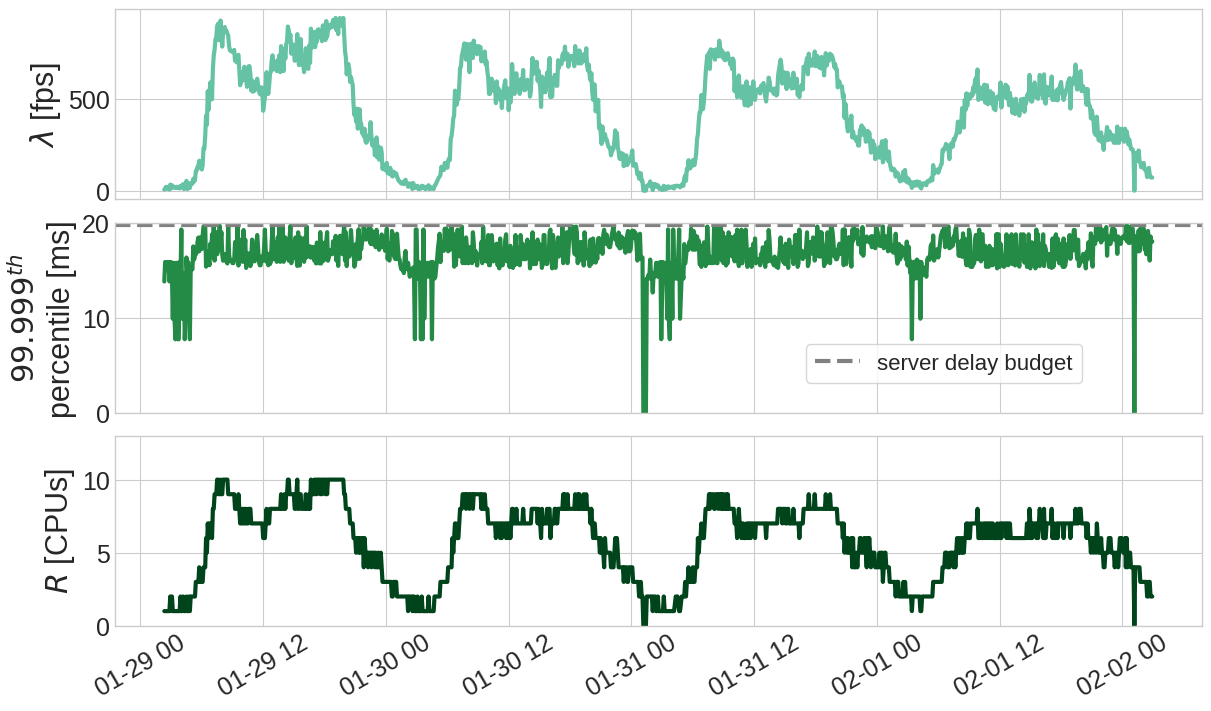

In [21]:
import itertools
import seaborn as sns


# method colors
res = res_h15dB
Rs = [res[i][0] for i in range(len(res))]
delps = [res[i][1] for i in range(len(res_h))]
rhos = [highway_lambdas['lambda_v2x'][off:period+off][i]/(res[i][0]*mu) for i in range(len(res))]
attended_lmbd = [res[i][4] for i in range(len(res))] 
#method_idxs = np.array([res[i][2] for i in range(len(res))])

#print(np.unique(method_idxs))


palette = itertools.cycle(sns.color_palette())


##x = range(len(Rs))
x = highway_lambdas['lambda_v2x'][off:period+off].index

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,7),
                       constrained_layout=True)


#axs[0].plot(x, highway_lambdas['lambda_v2x'][off:period+off], color='#66c2a4', lw=3, label='demand')
axs[0].plot(x, attended_lmbd, color='#66c2a4', lw=3)
axs[0].set_ylabel(r'$\lambda$ [fps]', fontsize=22)


c = next(palette)
axs[1].plot(x, delps, color='#238b45', lw=3)
axs[1].set_ylabel(r'$99.999^{th}$' + "\npercentile [ms]", fontsize=22)
axs[1].axhline(20-0.25, ls='dashed', color='gray', label='server delay budget', lw=3)
#axs[1].annotate('max network RTT = 28ms',  horizontalalignment='left',
#                xy=(.24,.8),  xycoords='axes fraction',
#                color='gray', fontsize=16, weight='bold',
#                xytext=(0.24,.835), textcoords='axes fraction')
#axs[1].annotate("",
#            xy=(0.22, 0.75), xycoords='axes fraction',
#            xytext=(0.22, 0.99), textcoords='axes fraction',
#            arrowprops=dict(arrowstyle="<->", color='gray', #fb6a4a
#                            lw=2,
#                            connectionstyle="arc3"),
#            )
axs[1].legend(frameon=True, fontsize=16, loc='lower right',
             bbox_to_anchor=[.9,.1])
axs[1].set_ylim(0,20)

c = next(palette)
axs[2].plot(x, Rs, color='#00441b', lw=3)
axs[2].set_ylabel(r'$R$ [CPUs]', fontsize=22)
axs[2].set_ylim(0,13)


for i in [0,1,2]:
    axs[i].tick_params(axis='both', which='major', labelsize=18)

plt.xticks(rotation=30)
plt.savefig(f'plots/scale-snapshot-highway.pdf', transparent=True, bbox_inches='tight')

#for idx in range(1,len(cols)+1):
#    if idx in method_idxs:
#        axs[3].fill_between(x, 0,1000, color=cols[idx-1], where=method_idxs==idx,
#                        label='ABCDEF'[idx-1])
#axs[3].set_ylim(0,1)    
#axs[3].set_yticks([])
#axs[3].legend(ncol=4)


# TODO: add space,use timestamps, add grid

/tmp/ipykernel_10723/4105535678.py:9: RuntimeWarning: invalid value encountered in scalar divide
  rhos = [industrial_lambdas['lambda_v2x'][off:period+off][i]/(res_i15dB[i][0]*mu) for i in range(len(res))]


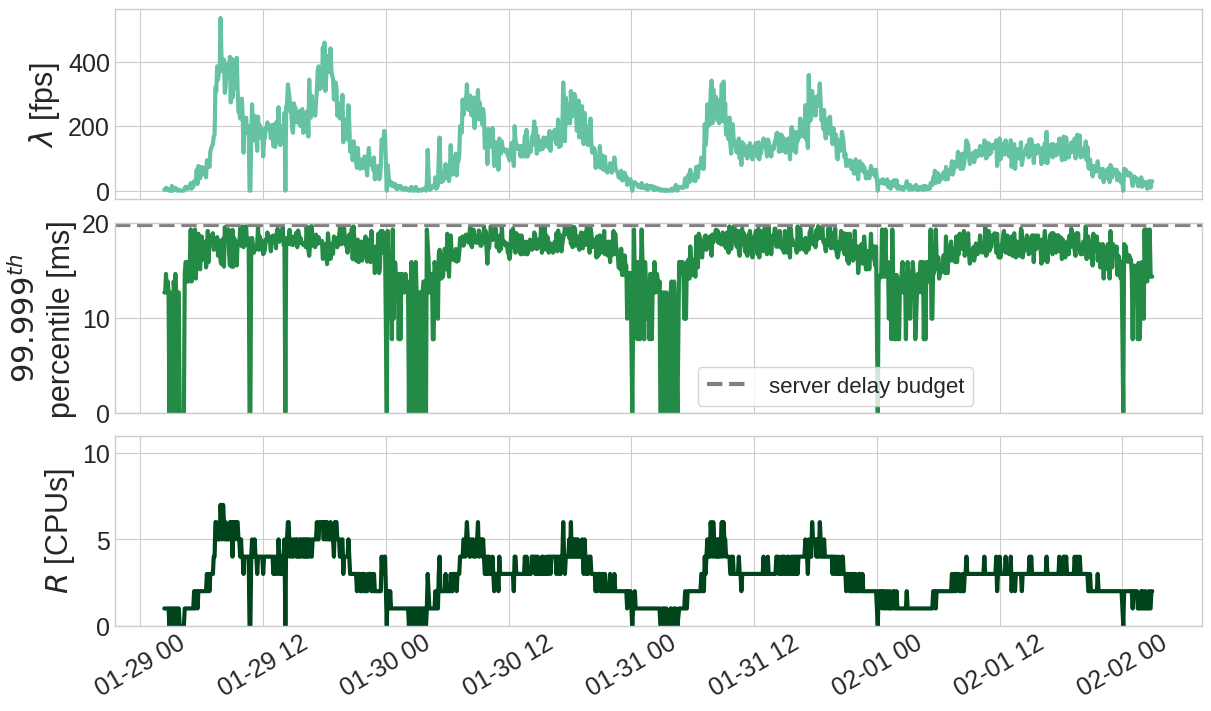

In [22]:
import itertools
import seaborn as sns


# method colors

Rs = [res_i15dB[i][0] for i in range(len(res))]
delps = [res_i15dB[i][1] for i in range(len(res))]
rhos = [industrial_lambdas['lambda_v2x'][off:period+off][i]/(res_i15dB[i][0]*mu) for i in range(len(res))]
attended_lmbd = [res_i15dB[i][4] for i in range(len(res_i15dB))] 
#method_idxs = np.array([res[i][2] for i in range(len(res))])

#print(np.unique(method_idxs))


palette = itertools.cycle(sns.color_palette())


##x = range(len(Rs))
x = industrial_lambdas['lambda_v2x'][off:period+off].index

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,7),
                       constrained_layout=True)


#axs[0].plot(x, industrial_lambdas['lambda_v2x'][off:period+off], color='#66c2a4', lw=3, label='demand')
axs[0].plot(x, attended_lmbd, color='#66c2a4', lw=3, label='attended')
# axs[0].legend(frameon=True, fontsize=16, loc='lower right',
#               ncols=2, bbox_to_anchor=[.95,.7])
axs[0].set_ylabel(r'$\lambda$ [fps]', fontsize=22)

c = next(palette)
axs[1].plot(x, delps, color='#238b45', lw=3)
axs[1].set_ylabel(r'$99.999^{th}$' + "\npercentile [ms]", fontsize=22)
axs[1].axhline(20-.25, ls='dashed', color='gray', label='server delay budget', lw=3)
# axs[1].annotate('max network RTT = 28ms',  horizontalalignment='left',
#                 xy=(.24,.8),  xycoords='axes fraction',
#                 color='gray', fontsize=16, weight='bold',
#                 xytext=(0.24,.835), textcoords='axes fraction')
# axs[1].annotate("",
#             xy=(0.22, 0.75), xycoords='axes fraction',
#             xytext=(0.22, 0.99), textcoords='axes fraction',
#             arrowprops=dict(arrowstyle="<->", color='gray', #fb6a4a
#                             lw=2,
#                             connectionstyle="arc3"),
#             )
axs[1].legend(frameon=True, fontsize=16, loc='upper right',
             bbox_to_anchor=[.8,.3])
axs[1].set_ylim(0,20)

c = next(palette)
axs[2].plot(x, Rs, color='#00441b', lw=3)
axs[2].set_ylabel(r'$R$ [CPUs]', fontsize=22)
axs[2].set_ylim(0,11)


for i in [0,1,2]:
    axs[i].tick_params(axis='both', which='major', labelsize=18)

plt.xticks(rotation=30)
plt.savefig(f'plots/scale-snapshot-industrial.pdf', transparent=True, bbox_inches='tight')

#for idx in range(1,len(cols)+1):
#    if idx in method_idxs:
#        axs[3].fill_between(x, 0,1000, color=cols[idx-1], where=method_idxs==idx,
#                        label='ABCDEF'[idx-1])
#axs[3].set_ylim(0,1)    
#axs[3].set_yticks([])
#axs[3].legend(ncol=4)


# TODO: add space,use timestamps, add grid

/tmp/ipykernel_9081/1619771460.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  rhos = [lowemission_lambdas['lambda_v2x'][off:period+off][i]/(res[i][0]*mu) for i in range(len(res))]
/tmp/ipykernel_9081/1619771460.py:9: RuntimeWarning: invalid value encountered in scalar divide
  rhos = [lowemission_lambdas['lambda_v2x'][off:period+off][i]/(res[i][0]*mu) for i in range(len(res))]


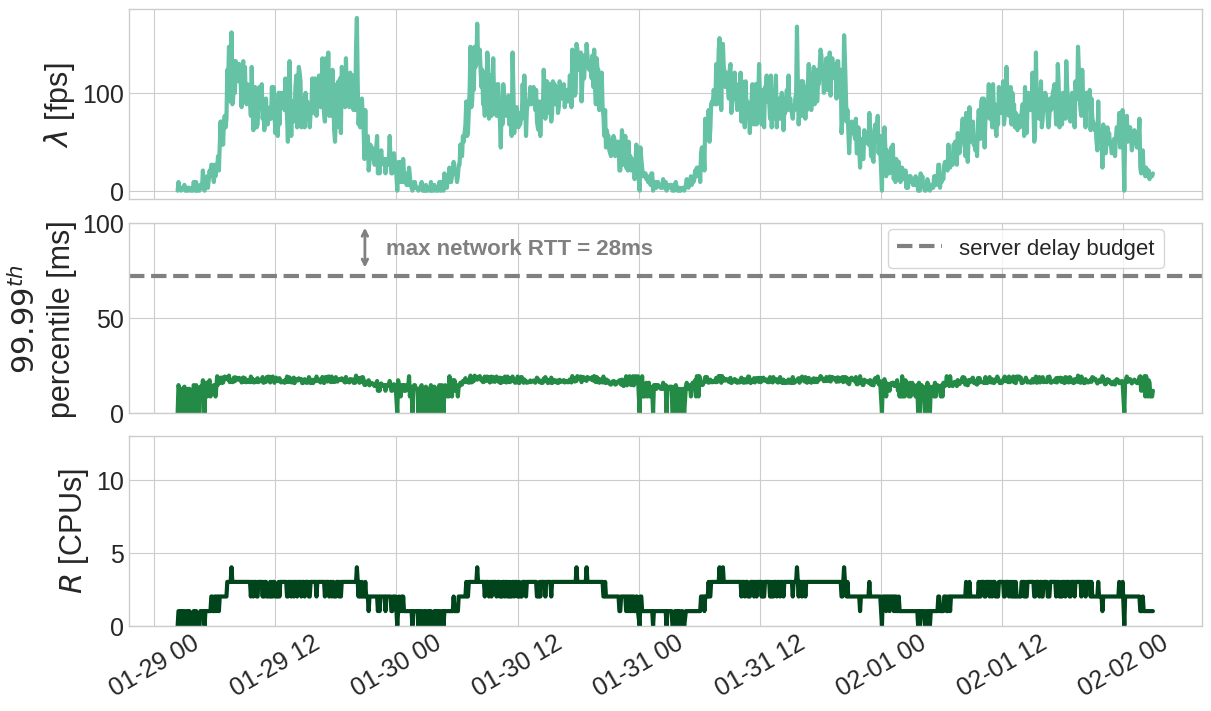

In [24]:
import itertools
import seaborn as sns


# method colors

Rs = [res_l[i][0] for i in range(len(res))]
delps = [res_l[i][1] for i in range(len(res))]
rhos = [lowemission_lambdas['lambda_v2x'][off:period+off][i]/(res[i][0]*mu) for i in range(len(res))]
#method_idxs = np.array([res[i][2] for i in range(len(res))])

#print(np.unique(method_idxs))


palette = itertools.cycle(sns.color_palette())


##x = range(len(Rs))
x = lowemission_lambdas['lambda_v2x'][off:period+off].index

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,7),
                       constrained_layout=True)


axs[0].plot(x, lowemission_lambdas['lambda_v2x'][off:period+off], color='#66c2a4', lw=3)
axs[0].set_ylabel(r'$\lambda$ [fps]', fontsize=22)

c = next(palette)
axs[1].plot(x, delps, color='#238b45', lw=3)
axs[1].set_ylabel(r'$99.99^{th}$' + "\npercentile [ms]", fontsize=22)
axs[1].axhline(100-28.095, ls='dashed', color='gray', label='server delay budget', lw=3)
axs[1].annotate('max network RTT = 28ms',  horizontalalignment='left',
                xy=(.24,.8),  xycoords='axes fraction',
                color='gray', fontsize=16, weight='bold',
                xytext=(0.24,.835), textcoords='axes fraction')
axs[1].annotate("",
            xy=(0.22, 0.75), xycoords='axes fraction',
            xytext=(0.22, 0.99), textcoords='axes fraction',
            arrowprops=dict(arrowstyle="<->", color='gray', #fb6a4a
                            lw=2,
                            connectionstyle="arc3"),
            )
axs[1].legend(frameon=True, fontsize=16, loc='upper right',
             bbox_to_anchor=[.975,1.025])
axs[1].set_ylim(0,100)

c = next(palette)
axs[2].plot(x, Rs, color='#00441b', lw=3)
axs[2].set_ylabel(r'$R$ [CPUs]', fontsize=22)
axs[2].set_ylim(0,13)


for i in [0,1,2]:
    axs[i].tick_params(axis='both', which='major', labelsize=18)

plt.xticks(rotation=30)
plt.savefig(f'plots/scale-snapshot-lowemission.pdf', transparent=True, bbox_inches='tight')

#for idx in range(1,len(cols)+1):
#    if idx in method_idxs:
#        axs[3].fill_between(x, 0,1000, color=cols[idx-1], where=method_idxs==idx,
#                        label='ABCDEF'[idx-1])
#axs[3].set_ylim(0,1)    
#axs[3].set_yticks([])
#axs[3].legend(ncol=4)


# TODO: add space,use timestamps, add grid

/tmp/ipykernel_38404/2361222993.py:9: RuntimeWarning: invalid value encountered in scalar divide
  rhos = [residential_lambdas['lambda_v2x'][off:period+off][i]/(res_r15dB[i][0]*mu) for i in range(len(res_r15dB))]


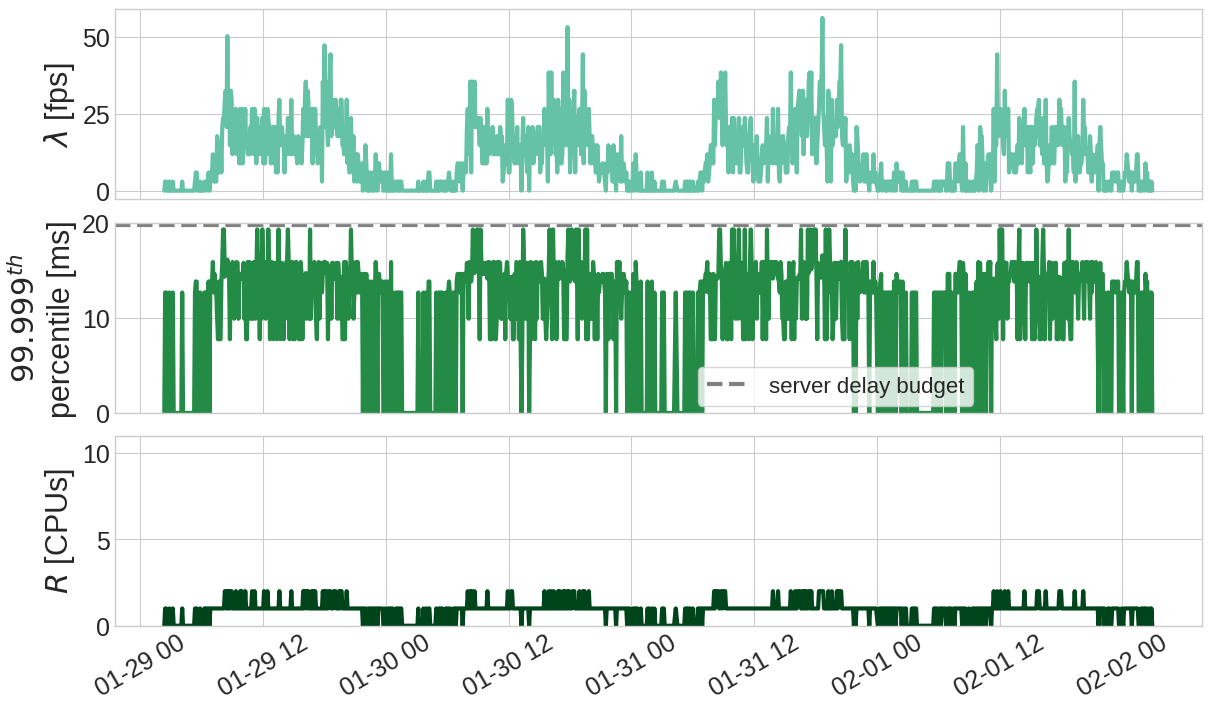

In [48]:
import itertools
import seaborn as sns


# method colors

Rs = [res_r15dB[i][0] for i in range(len(res_r15dB))]
delps = [res_r15dB[i][1] for i in range(len(res_r15dB))]
rhos = [residential_lambdas['lambda_v2x'][off:period+off][i]/(res_r15dB[i][0]*mu) for i in range(len(res_r15dB))]
attended_lmbd = [res_r15dB[i][4] for i in range(len(res_r15dB))] 
#method_idxs = np.array([res[i][2] for i in range(len(res))])

#print(np.unique(method_idxs))


palette = itertools.cycle(sns.color_palette())


##x = range(len(Rs))
x = residential_lambdas['lambda_v2x'][off:period+off].index

fig, axs = plt.subplots(3, 1, sharex=True, figsize=(12,7),
                       constrained_layout=True)


#axs[0].plot(x, residential_lambdas['lambda_v2x'][off:period+off], color='#66c2a4', lw=3, label='demand')
axs[0].plot(x, attended_lmbd, color='#66c2a4', lw=3)
# axs[0].legend(frameon=True, fontsize=16, loc='lower right',
#               ncols=2, bbox_to_anchor=[.95,.7])
axs[0].set_ylabel(r'$\lambda$ [fps]', fontsize=22)

c = next(palette)
axs[1].plot(x, delps, color='#238b45', lw=3)
axs[1].set_ylabel(r'$99.999^{th}$' + "\npercentile [ms]", fontsize=22)
axs[1].axhline(20-.25, ls='dashed', color='gray', label='server delay budget', lw=3)
# axs[1].annotate('max network RTT = 28ms',  horizontalalignment='left',
#                 xy=(.24,.8),  xycoords='axes fraction',
#                 color='gray', fontsize=16, weight='bold',
#                 xytext=(0.24,.835), textcoords='axes fraction')
# axs[1].annotate("",
#             xy=(0.22, 0.75), xycoords='axes fraction',
#             xytext=(0.22, 0.99), textcoords='axes fraction',
#             arrowprops=dict(arrowstyle="<->", color='gray', #fb6a4a
#                             lw=2,
#                             connectionstyle="arc3"),
#             )
axs[1].legend(frameon=True, fontsize=16, loc='upper right',
             bbox_to_anchor=[.8,.3])
axs[1].set_ylim(0,20)

c = next(palette)
axs[2].plot(x, Rs, color='#00441b', lw=3)
axs[2].set_ylabel(r'$R$ [CPUs]', fontsize=22)
axs[2].set_ylim(0,11)


for i in [0,1,2]:
    axs[i].tick_params(axis='both', which='major', labelsize=18)

plt.xticks(rotation=30)
plt.savefig(f'plots/scale-snapshot-residential.pdf', transparent=True, bbox_inches='tight')

#for idx in range(1,len(cols)+1):
#    if idx in method_idxs:
#        axs[3].fill_between(x, 0,1000, color=cols[idx-1], where=method_idxs==idx,
#                        label='ABCDEF'[idx-1])
#axs[3].set_ylim(0,1)    
#axs[3].set_yticks([])
#axs[3].legend(ncol=4)


# TODO: add space,use timestamps, add grid

In [27]:
rho = 0.9

1/(1-rho)/1

10.000000000000002

# Compare the scaling efficiency

Depending on whether service times are more similar to deterministic, or uniform; the CDF results will differ so as the number of CPUs.

In [25]:
# Load the results for industrial, residential, highway, low emissions

scenarios = {
    'industrial': {'lambdas': industrial_lambdas},
    'residential': {'lambdas': residential_lambdas},
    'highway': {'lambdas': highway_lambdas},
    'lowemission': {'lambdas': lowemission_lambdas},
}

In [26]:
# Compute the scaling results for each scenario, and every distribution

for sce in scenarios.keys():
    print(f'Scenario: {sce}')
    for dist, cdfs_ in [('approx', cdfs), ('unif', unif_cdfs), ('det', det_cdfs), ('exp', exp_cdfs)]:
        data = None if dist!='approx' else data
        scenarios[sce][dist] = scenarios[sce]['lambdas']['lambda_v2x'].apply(
            lambda l: smart_scaling(l, mu, 20, 0.99999, cdfs_, data=data, max_admission=max_admission15dB))

Scenario: industrial
Scenario: residential
Scenario: highway
Scenario: lowemission


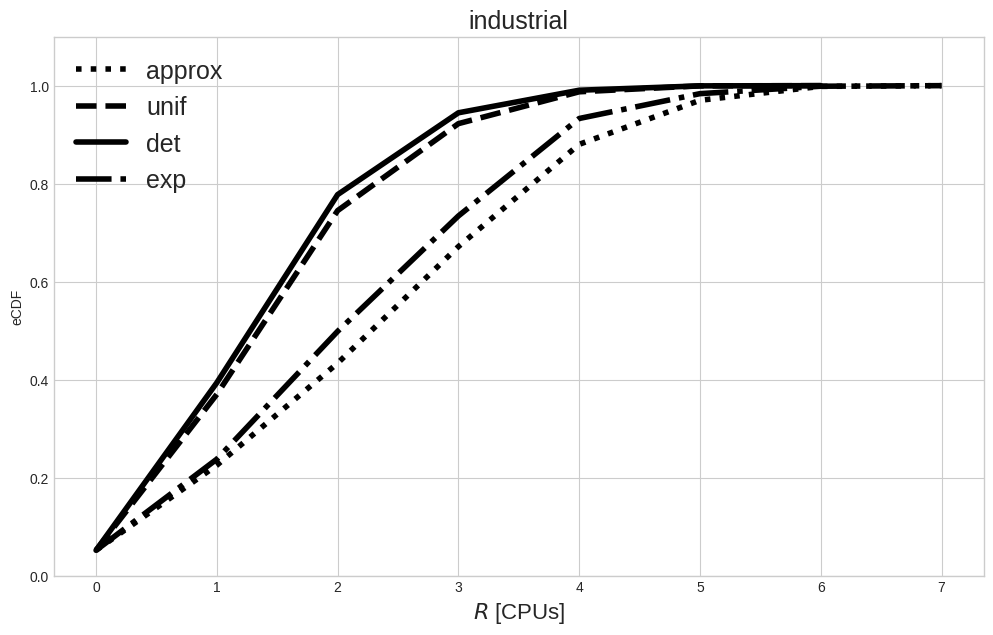

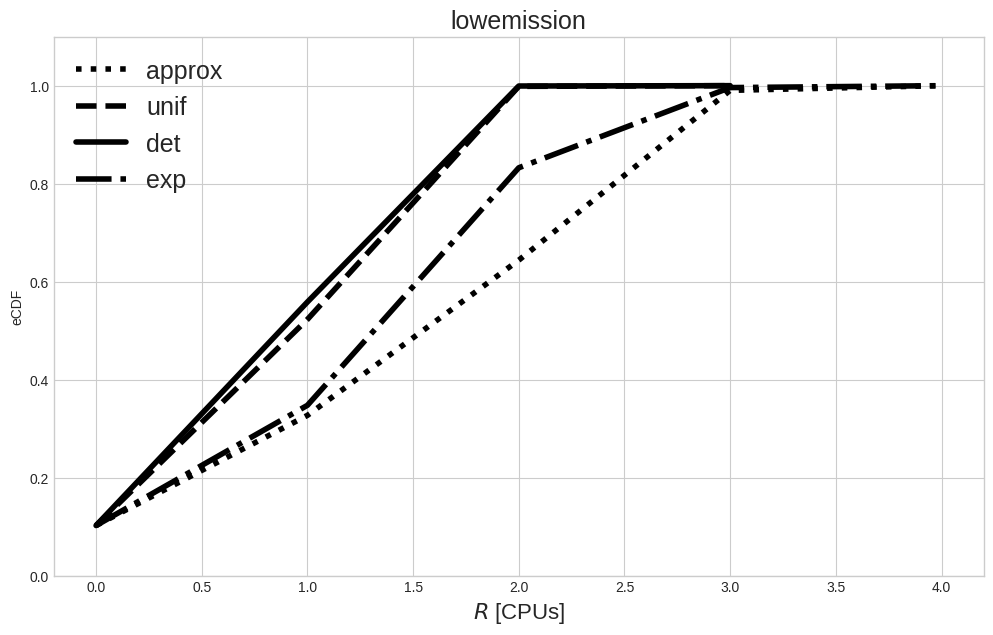

In [27]:
# Compare the number of CPUs required by every distribution

import matplotlib as mpl


lss = {
    'approx': 'dotted',
    'unif': 'dashed',
    'det': 'solid',
    'exp': 'dashdot'
}

markers = {
    'approx': (4,0,45),
    'unif': (2,0,0),
    'det': (4,2,45),
    'dashdot': (4,0,0),
}

#plt.gca().set_aspect('equal')



num_lambds = len(scenarios['industrial']['lambdas'])

## Plot the eCDF for the #CPUs ##
for sce in scenarios.keys():
    fig, ax = plt.subplots(1,1, figsize=(12,7))
    
    for dist in ['approx', 'unif', 'det', 'exp']:        
        R = [scenarios[sce][dist][i][0] for i in range(num_lambds)]
        # CDF - https://stackoverflow.com/a/30460089
        X2 = np.sort(R)
        F2 = np.array(range(len(R)))/float(len(R))
        X2_ = np.unique(X2)
        F2_ = [max(F2[X2==r]) for r in X2_]
        #
        ax.plot(X2_, F2_, label=dist, ls=lss[dist], color='black',
                 lw=4)
                 #marker=markers[dist], markerfacecolor='none',
                 #markersize=10, )
    plt.xlabel(r'$R$ [CPUs]', fontsize=16)
    plt.ylim(0,1.1)
    plt.ylabel('eCDF')
    plt.legend(fontsize=18)
    plt.title(sce, fontsize=18)
    plt.savefig(f'plots/cpus-cdf-{sce}.pdf', transparent=True, bbox_inches='tight')
    plt.show()
    
    

# Compare the 99.999-percentile delays

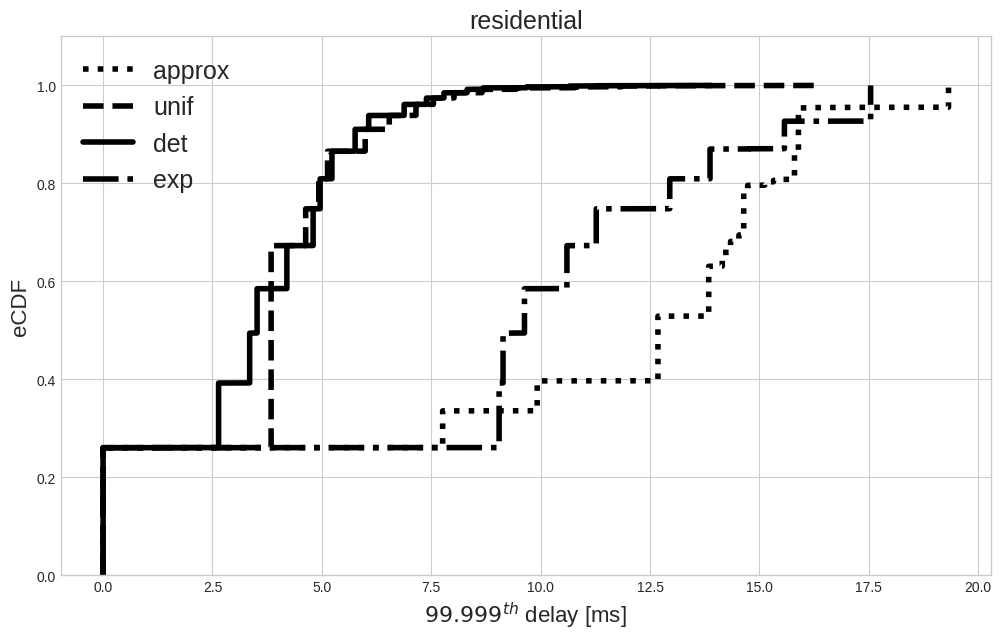

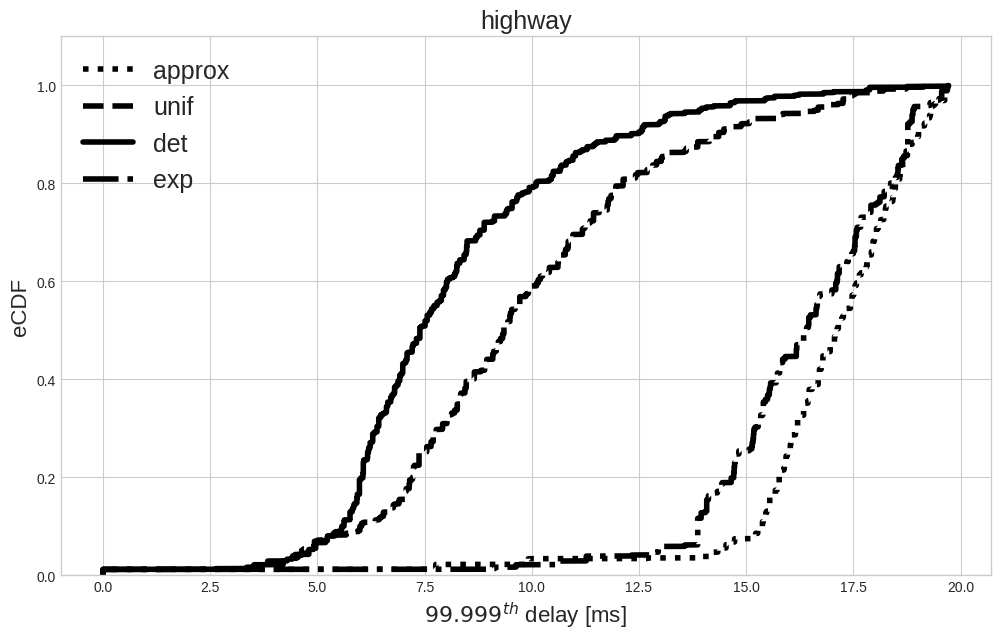

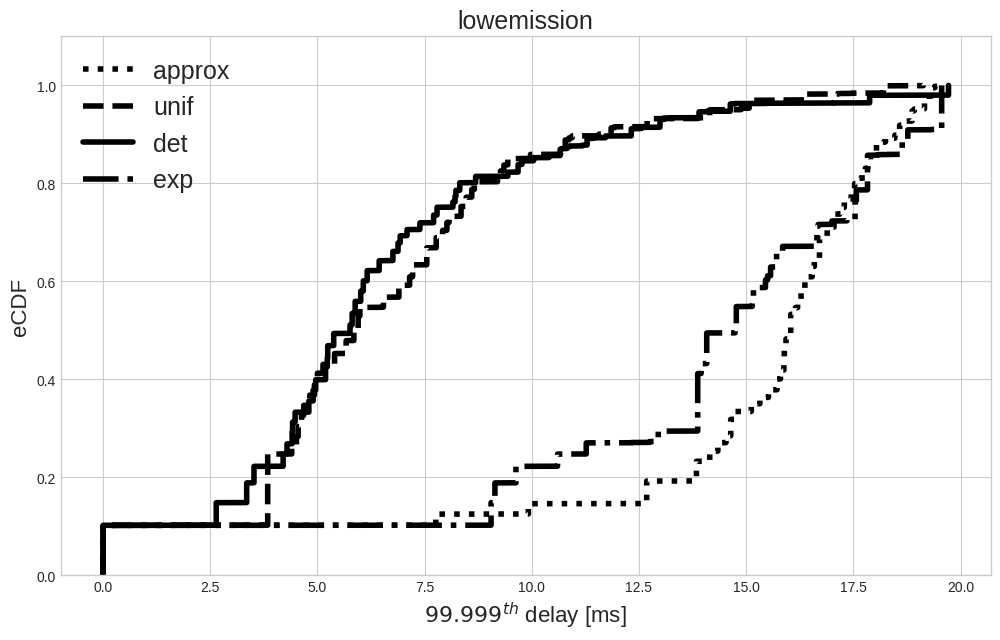

In [52]:

## Plot the eCDF for the 99.999-percentile delay ##
for sce in scenarios.keys():
    fig, ax = plt.subplots(1,1, figsize=(12,7))
    
    for dist in ['approx', 'unif', 'det', 'exp']:        
        d = [scenarios[sce][dist][i][1] for i in range(num_lambds)]
        # CDF - https://stackoverflow.com/a/30460089
        X2 = np.sort(d)
        F2 = np.array(range(len(d)))/float(len(d))
        #
        #fig = plt.figure(figsize=(12, 7))
        ax.plot(X2, F2, label=dist, ls=lss[dist], color='black',
                 lw=4)
                 #marker=markers[dist], markerfacecolor='none',
                 #markersize=5, markevery=300)
    plt.xlabel(r'$99.999^{th}$ delay [ms]', fontsize=16)
    plt.ylabel('eCDF', fontsize=16)
    plt.ylim(0,1.1)
    plt.legend(fontsize=18)
    plt.title(sce, fontsize=18)
    plt.savefig(f'plots/delays-cdf-{sce}.pdf', transparent=True, bbox_inches='tight')
    plt.show()

# Compare the CPU differences

In [23]:
a, b =enumerate(['A','N'])

print(a,b)

(0, 'A') (1, 'N')


In [28]:
# Compute scaling differences

dRs_dict = {}
for sce in scenarios.keys():
    for dist in ['exp', 'unif', 'det']:
        dRs_dict[sce,dist] = [scenarios[sce]['approx'][i][0] -\
              scenarios[sce][dist][i][0]\
              for i in range(num_lambds)]

exp residential [0 1] [6669  194]
exp industrial [-1  0  1] [ 116 5214 1533]
exp highway [-2 -1  0  1] [ 155 1794 4031  883]
unif residential [0 1] [6248  615]
unif industrial [0 1 2] [2105 3716 1042]
unif highway [0 1 2] [1816 4434  613]
det residential [0 1] [6248  615]
det industrial [0 1 2] [1820 3725 1318]
det highway [0 1 2] [1606 4515  742]


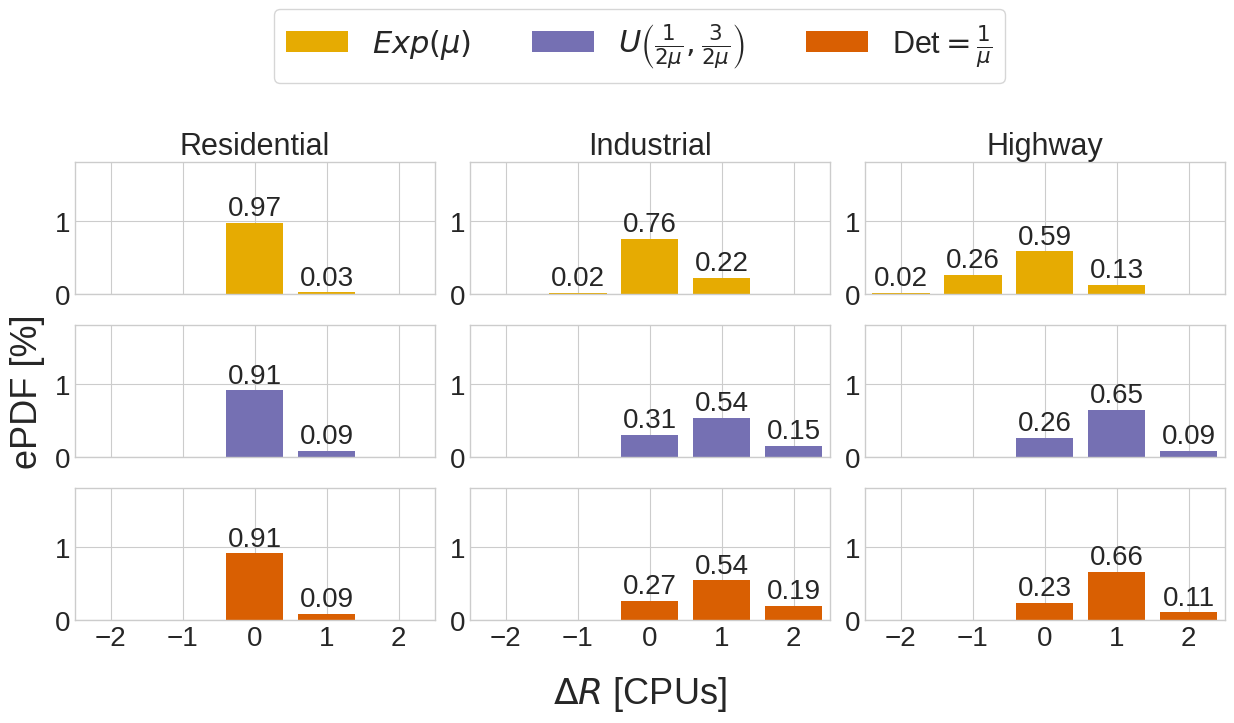

In [30]:
# https://colorbrewer2.org/#type=qualitative&scheme=Accent&n=6
#7fc97f
#beaed4
#fdc086
#ffff99
#386cb0
#f0027f
dist_cols = {
    'approx': 'black',
    'exp': '#e6ab02', #yellow
    'unif': '#7570b3', #blue
    'det': '#d95f02', #red
}


fig, axs = plt.subplots(3,3, figsize=(12,5.5), sharex=True, sharey=False, tight_layout=True)
for i, dist in enumerate(['exp', 'unif', 'det']):
    for j, sce in enumerate(['residential', 'industrial', 'highway']):
    

        dRs = dRs_dict[sce,dist]
        labels, counts = np.unique(dRs, return_counts=True)
        print(dist, sce, labels, counts)
        if dist=='exp':
            dname=r'$Exp(\mu)$'
        elif dist=='unif':
            dname=r'$U\left(\frac{1}{2\mu},\frac{3}{2\mu}\right)$'
        elif dist=='det':
            dname=r'Det$=\frac{1}{\mu}$'
        label = dname if j == 0 else None
        bars = axs[i][j].bar(labels, counts/len(dRs), align='center',
                     label=label, color=dist_cols[dist])
        for rect in bars:
            height = rect.get_height()
            axs[i][j].text(rect.get_x() + rect.get_width()/2.0,
                     height+.02, '{:.2f}'.format(height), ha='center', va='bottom',
                     rotation=0, fontsize=20) 
        if i==0:
            axs[i][j].set_title(sce.capitalize(), fontsize=22)

        axs[i][j].set_xlim(-2.5,2.5)
        axs[i][j].set_xticks([-2,-1,0,1,2])
        #axs[i][j].set_xticlabels(fontsize=22)
        axs[i][j].set_ylim(0,1.8)
        axs[i][j].tick_params(labelsize=20)
        
        # plt.legend(fontsize=18)
        #plt.title(sce, fontsize=18)
        #axs[i][j].grid(False)


#plt.xlabel()
fig.text(0.5,-0.05, r'$\Delta R$ [CPUs]', fontsize=26, ha="center", va="center")
fig.text(-.01,0.5, "ePDF [%]", fontsize=26, ha="center", va="center",
        rotation=90)
fig.legend(loc='upper center', frameon=True, ncol=3, fontsize=22, bbox_to_anchor=(0., 1.12, 1., .102))


plt.savefig(f'plots/delta-R.pdf', transparent=True, bbox_inches='tight')
plt.show()

# Compare the sojourn time percentiles using the approx.-scaling

In [56]:
scenarios['industrial']['unif'][0][-1]
scenarios.keys()

dict_keys(['industrial', 'residential', 'highway', 'lowemission'])

In [57]:
# Compute sojourn time differences

sojs_dict = {sce: {} for sce in scenarios.keys()}

for sce in ['residential', 'lowemission', 'highway', 'industrial'] :
    for dist, dist_cdfs in [('exp', exp_cdfs), ('unif', unif_cdfs), ('det', det_cdfs)]:
        
        sojs_dict[sce][dist] = []
        
        for i in range(num_lambds):
            approx_R = scenarios[sce]['approx'][i][0]
            approx_delp = scenarios[sce]['approx'][i][1]
            
            #lmbd = scenarios[sce]['lambdas']['lambda_v2x'].values[i]
            lmbd = scenarios[sce][dist].values[i][4] # set as lmbd the attended demand

            # We obtain the main server load and the leftover for the other servers
            if approx_R > 10:
                lmbd_main = scenarios[sce]['approx'][i][-1]
                lmbd_residual = lmbd - lmbd_main
                rho_main = round(lmbd_main/(10*mu), 2) if lmbd!=0 else 0
                rho_residual = round(lmbd_residual/( (approx_R-10) *mu), 2) if lmbd!=0 else 0
            else:
                lmbd_main = lmbd
                lmbd_residual = 0
                rho_main = round(lmbd/(approx_R*mu), 2) if lmbd!=0 else 0
                rho_residual = 0
            
            if rho_main == 0:
                delp = approx_delp
            else:
                delp_main = get_percentiles(lmbd_main, mu, min(approx_R,10), .99999, dist_cdfs)
                delp_residual = get_percentiles(lmbd_residual, mu, approx_R-10, .99999, dist_cdfs) if lmbd_residual>0 else 0
                delp = max(delp_main, delp_residual)
            
            if dist=='exp' and sce=='residential':
                #print(delp, approx_delp)
                pass
            sojs_dict[sce][dist].append(approx_delp - delp)

9.369999999999845 11.369999999999802
9.369999999999845 11.369999999999802
15.16999999999972 14.549999999999734
9.369999999999845 11.369999999999802
10.119999999999829 12.249999999999783
9.13999999999985 10.809999999999814
9.369999999999845 11.369999999999802
11.4899999999998 10.309999999999825
11.4899999999998 10.309999999999825
11.4899999999998 10.309999999999825
10.119999999999829 12.249999999999783
9.369999999999845 11.369999999999802
10.119999999999829 12.249999999999783
10.909999999999812 8.369999999999866
9.369999999999845 11.369999999999802
15.729999999999707 13.119999999999765
9.369999999999845 11.369999999999802
10.909999999999812 8.369999999999866
9.13999999999985 10.809999999999814
9.369999999999845 11.369999999999802
18.720000000000127 18.04000000000002
10.909999999999812 8.369999999999866
11.4899999999998 10.309999999999825
10.119999999999829 12.249999999999783
15.16999999999972 14.549999999999734
19.76000000000029 20.510000000000407
16.6399999999998 16.37999999999976
10.9

19.76000000000029 20.510000000000407
15.729999999999707 13.119999999999765
11.4899999999998 10.309999999999825
21.94000000000063 21.590000000000572
15.729999999999707 13.119999999999765
10.909999999999812 8.369999999999866
10.909999999999812 8.369999999999866
19.76000000000029 20.510000000000407
15.729999999999707 13.119999999999765
18.720000000000127 18.04000000000002
18.720000000000127 18.04000000000002
18.720000000000127 18.04000000000002
24.54000000000104 26.720000000001377
19.50000000000025 19.020000000000174
16.6399999999998 16.37999999999976
15.729999999999707 13.119999999999765
15.729999999999707 13.119999999999765
15.729999999999707 13.119999999999765
10.909999999999812 8.369999999999866
19.76000000000029 20.510000000000407
16.6399999999998 16.37999999999976
21.94000000000063 21.590000000000572
15.729999999999707 13.119999999999765
21.94000000000063 21.590000000000572
22.730000000000757 23.35000000000085
9.13999999999985 10.809999999999814
11.4899999999998 10.309999999999825
1

11.4899999999998 10.309999999999825
15.729999999999707 13.119999999999765
10.119999999999829 12.249999999999783
10.119999999999829 12.249999999999783
10.909999999999812 8.369999999999866
0 0
9.13999999999985 10.809999999999814
0 0
0 0
9.13999999999985 10.809999999999814
0 0
9.13999999999985 10.809999999999814
9.13999999999985 10.809999999999814
9.369999999999845 11.369999999999802
9.13999999999985 10.809999999999814
9.049999999999851 9.999999999999831
11.4899999999998 10.309999999999825
0 0
9.13999999999985 10.809999999999814
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
0 0
9.049999999999851 9.999999999999831
9.369999999999845 11.369999999999802
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
0 0
9.049999999999851 9.999999999999831
0 0
0 0
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
9.13999999999985 10

15.729999999999707 13.119999999999765
19.76000000000029 20.510000000000407
19.76000000000029 20.510000000000407
15.16999999999972 14.549999999999734
16.6399999999998 16.37999999999976
10.909999999999812 8.369999999999866
15.16999999999972 14.549999999999734
18.720000000000127 18.04000000000002
15.16999999999972 14.549999999999734
16.6399999999998 16.37999999999976
11.4899999999998 10.309999999999825
19.50000000000025 19.020000000000174
19.76000000000029 20.510000000000407
9.369999999999845 11.369999999999802
11.4899999999998 10.309999999999825
15.729999999999707 13.119999999999765
15.16999999999972 14.549999999999734
16.6399999999998 16.37999999999976
11.4899999999998 10.309999999999825
9.369999999999845 11.369999999999802
15.16999999999972 14.549999999999734
15.729999999999707 13.119999999999765
10.909999999999812 8.369999999999866
15.729999999999707 13.119999999999765
10.909999999999812 8.369999999999866
11.4899999999998 10.309999999999825
11.4899999999998 10.309999999999825
15.16999

In [58]:
scenarios['industrial']['unif'].values[0][1]

18.75000000000013

In [59]:
# Compute sojourn time differences

sojs_dict = {sce: {} for sce in scenarios.keys()}

for sce in ['residential', 'lowemission', 'highway', 'industrial'] :
    for dist, dist_cdfs in [('exp', exp_cdfs), ('unif', unif_cdfs), ('det', det_cdfs)]:
        
        sojs_dict[sce][dist] = []


        
        for i in range(num_lambds):
            approx_delp = scenarios[sce]['approx'].values[i][1]
            delp = scenarios[sce][dist].values[i][1]
            sojs_dict[sce][dist].append(approx_delp - delp)
                

9.13999999999985 10.809999999999814
0 0
0 0
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
0 0
9.049999999999851 9.999999999999831
0 0
0 0
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
9.369999999999845 11.369999999999802
9.369999999999845 11.369999999999802
9.369999999999845 11.369999999999802
9.049999999999851 9.999999999999831
9.369999999999845 11.369999999999802
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
9.049999999999851 9.999999999999831
10.119999999999829 12.249999999999783
10.119999999999829 12.249999999999783
11.4899999999998 10.309999999999825
15.729999999999707 13.119999999999765
9.13999999999985 10.809999999999814
15.16999999999972 14.549999999999734
15.16999999999972 14.549999999999

11.4899999999998 10.309999999999825
10.119999999999829 12.249999999999783
15.729999999999707 13.119999999999765
11.4899999999998 10.309999999999825
15.729999999999707 13.119999999999765
10.119999999999829 12.249999999999783
15.729999999999707 13.119999999999765
18.720000000000127 18.04000000000002
9.13999999999985 10.809999999999814
11.4899999999998 10.309999999999825
9.369999999999845 11.369999999999802
9.13999999999985 10.809999999999814
10.119999999999829 12.249999999999783
9.369999999999845 11.369999999999802
10.909999999999812 8.369999999999866
15.729999999999707 13.119999999999765
15.729999999999707 13.119999999999765
15.729999999999707 13.119999999999765
10.119999999999829 12.249999999999783
10.119999999999829 12.249999999999783
10.119999999999829 12.249999999999783
10.909999999999812 8.369999999999866
10.909999999999812 8.369999999999866
15.729999999999707 13.119999999999765
15.729999999999707 13.119999999999765
10.909999999999812 8.369999999999866
16.6399999999998 16.379999999

18.720000000000127 18.04000000000002
9.369999999999845 11.369999999999802
15.16999999999972 14.549999999999734
11.4899999999998 10.309999999999825
10.909999999999812 8.369999999999866
11.4899999999998 10.309999999999825
11.4899999999998 10.309999999999825
18.720000000000127 18.04000000000002
16.6399999999998 16.37999999999976
11.4899999999998 10.309999999999825
18.720000000000127 18.04000000000002
15.729999999999707 13.119999999999765
15.16999999999972 14.549999999999734
19.50000000000025 19.020000000000174
18.720000000000127 18.04000000000002
9.369999999999845 11.369999999999802
18.720000000000127 18.04000000000002
18.720000000000127 18.04000000000002
10.119999999999829 12.249999999999783
11.4899999999998 10.309999999999825
15.729999999999707 13.119999999999765
15.729999999999707 13.119999999999765
11.4899999999998 10.309999999999825
11.4899999999998 10.309999999999825
9.13999999999985 10.809999999999814
10.909999999999812 8.369999999999866
9.369999999999845 11.369999999999802
11.4899

9.049999999999851 9.999999999999831
0 0
0 0
0 0
9.13999999999985 10.809999999999814
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
11.4899999999998 10.309999999999825
0 0
9.13999999999985 10.809999999999814
0 0
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
9.049999999999851 9.999999999999831
0 0
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
0 0
0 0
9.049999999999851 9.999999999999831
9.369999999999845 11.369999999999802
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
0 0
9.13999999999985 10.809999999999814
0 0
9.049999999999851 9.999999999999831
0 0
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
9.049999999999851 9.999999999999831
0 0
0 0
0 0
9.049999999999851 9.999999999999831
0 0
0 0
9.049999999999851 9.999999999999831
0 0
9.049999999999851 9.99999999999

9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
0 0
0 0
0 0
0 0
9.049999999999851 9.999999999999831
0 0
0 0
9.049999999999851 9.999999999999831
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
9.13999999999985 10.809999999999814
0 0
0 0
0 0
0 0
9.049999999999851 9.999999999999831
0 0
9.049999999999851 9.999999999999831
0 0
0 0
0 0
0 0
0 0
0 0
9.049999999999851 9.999999999999831
0 0
9.049999999999851 9.999999999999831
0 0
0 0
0 0
9.13999999999985 10.809999999999814
0 0
0 0
0 0
9.049999999999851 9.999999999999831
0 0
0 0
9.13999999999985 10.809999999999814
0 0
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
0 0
9.13999999999985 10.809999999999814
9.049999999999851 9.999999999999831
9.369999999999845 11.369999999999802
0 0
9.049999999999851 9.999999999999831
0 0
0 0
9.049999999999851 9.999999999999831
0 0
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
9.049999999999851 9.999999999999831
0 0
0 0
0 0
9.049999999999851 9.9999999

9.369999999999845 11.369999999999802
9.369999999999845 11.369999999999802
15.16999999999972 14.549999999999734
9.369999999999845 11.369999999999802
10.119999999999829 12.249999999999783
9.13999999999985 10.809999999999814
9.369999999999845 11.369999999999802
11.4899999999998 10.309999999999825
11.4899999999998 10.309999999999825
11.4899999999998 10.309999999999825
10.119999999999829 12.249999999999783
9.369999999999845 11.369999999999802
10.119999999999829 12.249999999999783
10.909999999999812 8.369999999999866
9.369999999999845 11.369999999999802
15.729999999999707 13.119999999999765
9.369999999999845 11.369999999999802
10.909999999999812 8.369999999999866
9.13999999999985 10.809999999999814
9.369999999999845 11.369999999999802
18.720000000000127 18.04000000000002
10.909999999999812 8.369999999999866
11.4899999999998 10.309999999999825
10.119999999999829 12.249999999999783
15.16999999999972 14.549999999999734
19.76000000000029 20.510000000000407
16.6399999999998 16.37999999999976
10.9

19.76000000000029 20.510000000000407
15.729999999999707 13.119999999999765
11.4899999999998 10.309999999999825
21.94000000000063 21.590000000000572
15.729999999999707 13.119999999999765
10.909999999999812 8.369999999999866
10.909999999999812 8.369999999999866
19.76000000000029 20.510000000000407
15.729999999999707 13.119999999999765
18.720000000000127 18.04000000000002
18.720000000000127 18.04000000000002
18.720000000000127 18.04000000000002
24.54000000000104 26.720000000001377
19.50000000000025 19.020000000000174
16.6399999999998 16.37999999999976
15.729999999999707 13.119999999999765
15.729999999999707 13.119999999999765
15.729999999999707 13.119999999999765
10.909999999999812 8.369999999999866
19.76000000000029 20.510000000000407
16.6399999999998 16.37999999999976
21.94000000000063 21.590000000000572
15.729999999999707 13.119999999999765
21.94000000000063 21.590000000000572
22.730000000000757 23.35000000000085
9.13999999999985 10.809999999999814
11.4899999999998 10.309999999999825
1

11.4899999999998 10.309999999999825
15.729999999999707 13.119999999999765
10.119999999999829 12.249999999999783
10.119999999999829 12.249999999999783
10.909999999999812 8.369999999999866
0 0
9.13999999999985 10.809999999999814
0 0
0 0
9.13999999999985 10.809999999999814
0 0
9.13999999999985 10.809999999999814
9.13999999999985 10.809999999999814
9.369999999999845 11.369999999999802
9.13999999999985 10.809999999999814
9.049999999999851 9.999999999999831
11.4899999999998 10.309999999999825
0 0
9.13999999999985 10.809999999999814
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
9.049999999999851 9.999999999999831
0 0
9.049999999999851 9.999999999999831
9.369999999999845 11.369999999999802
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
0 0
9.049999999999851 9.999999999999831
0 0
0 0
9.049999999999851 9.999999999999831
9.13999999999985 10.809999999999814
9.13999999999985 10

15.729999999999707 13.119999999999765
19.76000000000029 20.510000000000407
19.76000000000029 20.510000000000407
15.16999999999972 14.549999999999734
16.6399999999998 16.37999999999976
10.909999999999812 8.369999999999866
15.16999999999972 14.549999999999734
18.720000000000127 18.04000000000002
15.16999999999972 14.549999999999734
16.6399999999998 16.37999999999976
11.4899999999998 10.309999999999825
19.50000000000025 19.020000000000174
19.76000000000029 20.510000000000407
9.369999999999845 11.369999999999802
11.4899999999998 10.309999999999825
15.729999999999707 13.119999999999765
15.16999999999972 14.549999999999734
16.6399999999998 16.37999999999976
11.4899999999998 10.309999999999825
9.369999999999845 11.369999999999802
15.16999999999972 14.549999999999734
15.729999999999707 13.119999999999765
10.909999999999812 8.369999999999866
15.729999999999707 13.119999999999765
10.909999999999812 8.369999999999866
11.4899999999998 10.309999999999825
11.4899999999998 10.309999999999825
15.16999

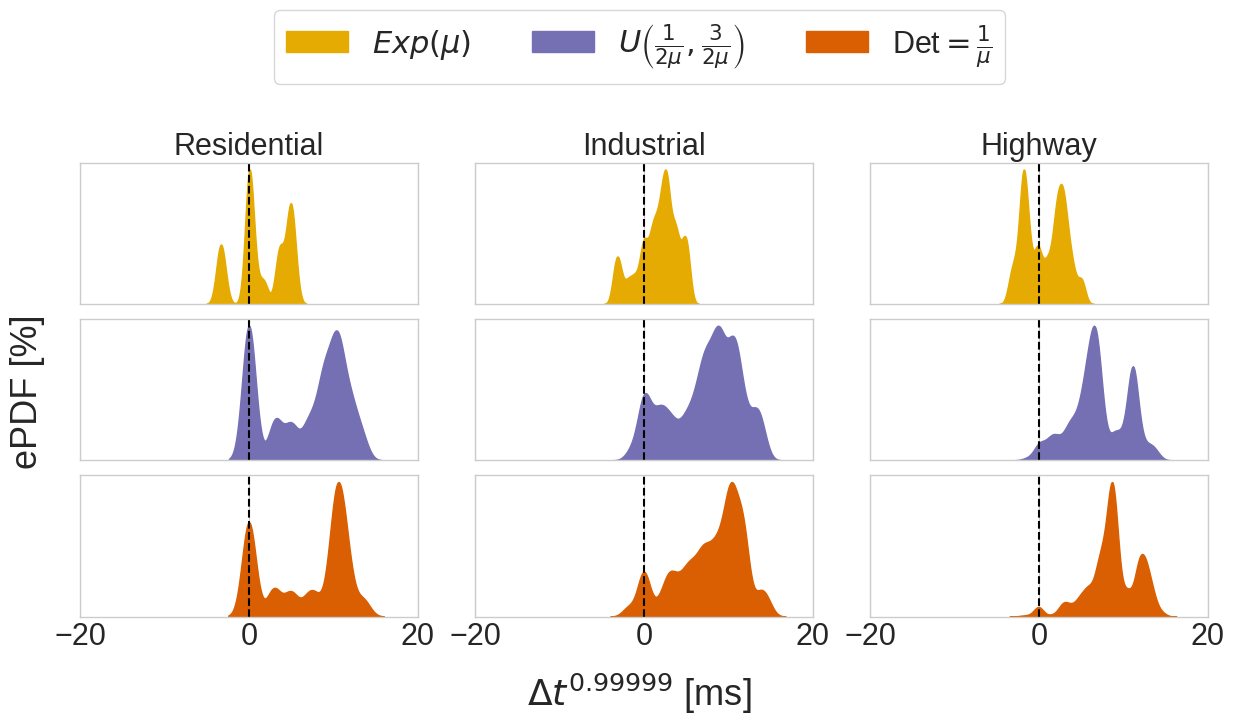

In [60]:
import seaborn as sns

fig, axs = plt.subplots(3,3, figsize=(12,5.5), sharex=True, sharey=False, tight_layout=True)
for i, dist in enumerate(['exp', 'unif', 'det']):
    for j, sce in enumerate(['residential', 'industrial', 'highway']):
    

        dRs = dRs_dict[sce,dist]
        labels, counts = np.unique(dRs, return_counts=True)
    
        if dist=='exp':
            dname=r'$Exp(\mu)$'
        elif dist=='unif':
            dname=r'$U\left(\frac{1}{2\mu},\frac{3}{2\mu}\right)$'
        elif dist=='det':
            dname=r'Det$=\frac{1}{\mu}$'
        label = dname if j == 0 else None
        sns.kdeplot(sojs_dict[sce][dist], ax=axs[i][j], fill=True,
                    alpha=1,
                    color=dist_cols[dist], label=label)
        
        if i==0:
            axs[i][j].set_title(sce.capitalize(), fontsize=22)

        #axs[i][j].hist(sojs_dict[sce][dist], bins=50,
        #               color=dist_cols[dist], label=label)
        
        axs[i][j].axvline(ymin=0, ymax=1, color='black', ls='dashed')
        axs[i][j].set_xlim(-20,20)
        axs[i][j].set_xticks([-20,0,20])
        axs[i][j].set_yticks([])
        #axs[i][j].set_ylim(0,.25)
        axs[i][j].set_ylabel(None)
        axs[i][j].tick_params(labelsize=22)

#plt.xlabel()
fig.text(0.5,-0.05, r'$\Delta t^{0.99999}$ [ms]', fontsize=26, ha="center", va="center")
fig.text(-.01,0.5, "ePDF [%]", fontsize=26, ha="center", va="center",
        rotation=90)
fig.legend(loc='upper center', frameon=True, ncol=3, fontsize=22, bbox_to_anchor=(0., 1.12, 1., .102))


plt.savefig(f'plots/delta-T.pdf', transparent=True, bbox_inches='tight')
plt.show()

In [37]:
sojs_dict['residential']['exp']

[-2.539999999999946,
 -0.26000000000004064,
 0.7500000000001172,
 -2.539999999999946,
 -0.48000000000007503,
 -2.539999999999946,
 -0.6800000000001063,
 -0.26000000000004064,
 -0.26000000000004064,
 2.1299999999999546,
 0.7500000000001172,
 -0.48000000000007503,
 2.1299999999999546,
 -0.619999999999985,
 -0.26000000000004064,
 -2.6099999999999426,
 -2.6099999999999426,
 -0.26000000000004064,
 0,
 0,
 0,
 -2.6099999999999426,
 -0.26000000000004064,
 -2.6099999999999426,
 1.6699999999999644,
 2.1299999999999546,
 -0.6800000000001063,
 -0.26000000000004064,
 -2.539999999999946,
 -1.1799999999999748,
 1.6699999999999644,
 -2.6099999999999426,
 -1.1799999999999748,
 2.1299999999999546,
 2.1299999999999546,
 1.9999999999999574,
 1.9999999999999574,
 0,
 2.1299999999999546,
 0,
 0.9499999999999797,
 1.6699999999999644,
 1.6699999999999644,
 1.6699999999999644,
 1.9999999999999574,
 1.6699999999999644,
 2.1299999999999546,
 -1.1799999999999748,
 1.9999999999999574,
 2.1299999999999546,
 2.1299

In [38]:
cdfs[3,0.3]

sojourn_time           cdf
0              0.00 -2.220446e-15
1              0.01  9.628788e-03
2              0.02  1.914644e-02
3              0.03  2.855445e-02
4              0.04  3.785432e-02
...             ...           ...
18228        182.28           NaN
18229        182.29           NaN
18230        182.30           NaN
18231        182.31           NaN
18232        182.32           NaN

[18233 rows x 2 columns]

In [39]:
exp_cdfs[3,.3]

sojourn_time       cdf
0              0.00  0.000000
1              0.01  0.009714
2              0.02  0.018841
3              0.03  0.028601
4              0.04  0.037341
...             ...       ...
18228        182.28  1.000000
18229        182.29  1.000000
18230        182.30  1.000000
18231        182.31  1.000000
18232        182.32  1.000000

[18233 rows x 2 columns]